### Fairness of prediction between rich and poor counties in the US using Prophet - Part 2 (Forecasting)

In [1]:
import pathlib
import warnings
import statistics
from os import walk
import pandas as pd
import import_ipynb
from methods import *
import seaborn as sns
from tqdm import tqdm
from prophet import Prophet
from tabulate import tabulate
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error

warnings.filterwarnings('ignore')

importing Jupyter notebook from methods.ipynb


#### Load data

In [3]:
# Load the data from part 1

tract_df = pd.read_hdf('tracts_fairness.h5')  
tract_df.head(5)

,STATENAME,MAKENAME,MAK_MODNAME,MOD_YEAR,LATITUDE,LONGITUD,YEAR,VPICBODYCLASSNAME,FIPS,LOCATION,RPL_THEMES,datetime
0,Alabama,Ford,Ford F-Series pickup,2003,33.878653,-87.325328,2015,0,01127,"Walker County, Alabama",0.7452,2015-01-01
1,Alabama,Ford,Ford F-Series pickup,2003,33.791964,-86.383703,2013,0,01115,"St. Clair County, Alabama",0.3656,2013-01-01
2,Alabama,Ford,Ford F-Series pickup,2003,33.426458,-86.819731,2016,0,01073,"Jefferson County, Alabama",0.6621,2016-01-01
3,Alabama,Ford,Ford F-Series pickup,2003,32.701317,-85.525181,2012,0,01081,"Lee County, Alabama",0.6602,2012-01-01
4,Alabama,Ford,Ford F-Series pickup,2003,32.433133,-86.094850,2020,0,01051,"Elmore County, Alabama",0.5401,2020-01-01


#### Visualizing make/year of car to check if svi impacts the 'counts'

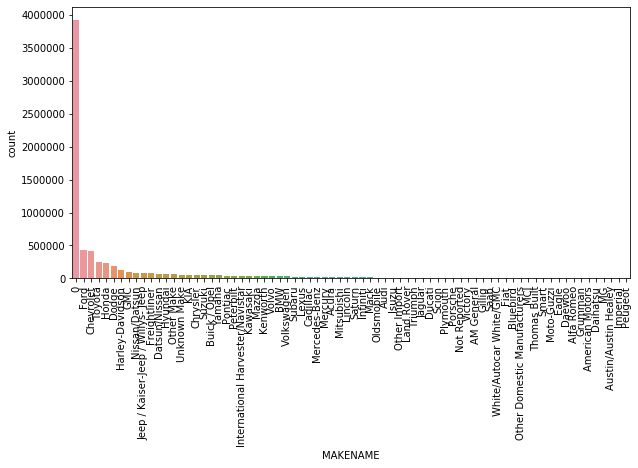

In [4]:
# Understanding if svi index impacts the make/year of car

plt.figure(figsize=(10,5))
plot1 = sns.countplot(x='MAKENAME',data=tract_df, order = 
                     tract_df['MAKENAME'].value_counts().index)

plot1.set_xticklabels(plot1.get_xticklabels(), rotation=90)
None

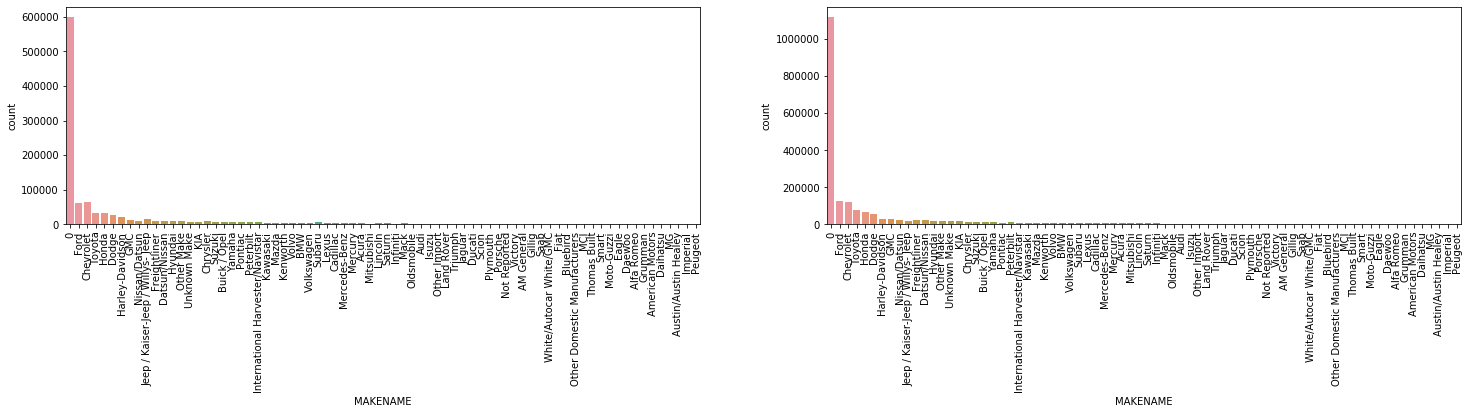

In [17]:
df_theme_rich = tract_df[tract_df['RPL_THEMES'] < 0.25]
df_theme_poor = tract_df[tract_df['RPL_THEMES'] > 0.75]

plt.rcParams["figure.figsize"] = [25, 4]
fig, ax =plt.subplots(1,2)

# plotting rich counties
plot1 = sns.countplot(x='MAKENAME',data=df_theme_rich, order = 
                     tract_df['MAKENAME'].value_counts().index, ax=ax[0])
plot1.set_xticklabels(plot1.get_xticklabels(), rotation=90)

# plotting poor counties
plot2 = sns.countplot(x='MAKENAME',data=df_theme_poor, order = 
                     tract_df['MAKENAME'].value_counts().index, ax=ax[1])
plot2.set_xticklabels(plot2.get_xticklabels(), rotation=90)
None

#### Train Prophet model with rich and poor counties

In [13]:
def svi_themes(tract_df):
    print("Group the data ........")   
    df_theme_rich = tract_df[tract_df['RPL_THEMES'] < 0.15]
    df_theme_poor = tract_df[tract_df['RPL_THEMES'] > 0.75]
    print(len(df_theme_rich.LOCATION.unique()))
    print(len(df_theme_poor.LOCATION.unique()))
    
    d_theme_rich = {}
    grouped_theme_rich = df_theme_rich.groupby(df_theme_rich.LOCATION)
    for i in df_theme_rich.LOCATION.unique():
        d_theme_rich[i] = pd.DataFrame()
        d_theme_rich[i] = grouped_theme_rich.get_group(str(i))

    d_theme_poor = {}
    grouped_theme_poor = df_theme_poor.groupby(df_theme_poor.LOCATION)
    for i in df_theme_poor.LOCATION.unique():
        d_theme_poor[i] = pd.DataFrame()
        d_theme_poor[i] = grouped_theme_poor.get_group(str(i))
        
    names_ref_rich = pd.DataFrame()
    names_ref_rich.insert(0, 'LOCATION', df_theme_rich.LOCATION.unique())
    for i in names_ref_rich.iterrows():
        names_ref_rich['reference'] = names_ref_rich.index
    
    names_ref_poor = pd.DataFrame()
    names_ref_poor.insert(0, 'LOCATION', df_theme_poor.LOCATION.unique())
    for i in names_ref_poor.iterrows():
        names_ref_poor['reference'] = names_ref_poor.index
        
    
    print("Start training - Rich Group........")      
    rich_score = []
    for i in tqdm(d_theme_rich.keys()):
        print(i)
        columns = ['datetime']
        new_df = d_theme_rich[i][columns].copy()
        new_df['date'] = new_df['datetime']

        count_df = pd.DataFrame()
        count_df['y'] = new_df['date'].value_counts()
        count_df['ds'] = pd.to_datetime(count_df.index)

        if(len(count_df) <= 15):
            del count_df
            names_ref_rich = names_ref_rich[names_ref_rich['LOCATION'] != i]
            continue
            
        count_df.sort_values(by='ds', inplace=True)
        
        model = Prophet(daily_seasonality=True)
        model.fit(count_df)
        future = model.make_future_dataframe(periods=5, freq = 'd')
        forecast = model.predict(future)
        metric_df = forecast.set_index('ds')[['yhat']].join(count_df.set_index('ds').y).reset_index()
        metric_df.dropna(inplace=True)

        r2 = r2_score(metric_df.y, metric_df.yhat)
        mae = mean_absolute_error(metric_df.y, metric_df.yhat)
        rich_score.append([r2,mae])
        
    print("Start training - Poor Group........")   
    poor_score = []
    for i in tqdm(d_theme_poor.keys()):
        print(i)
        columns = ['datetime']
        new_df = d_theme_poor[i][columns].copy()
        new_df['date'] = new_df['datetime']

        count_df = pd.DataFrame()
        count_df['y'] = new_df['date'].value_counts()
        count_df['ds'] = pd.to_datetime(count_df.index)
        
        if(len(count_df) <= 15):
            del count_df
            names_ref_poor = names_ref_poor[names_ref_poor['LOCATION'] != i]
            continue
        count_df.sort_values(by='ds', inplace=True)
        
        model = Prophet(daily_seasonality=True)
        model.fit(count_df)
        future = model.make_future_dataframe(periods=5, freq = 'd')
        forecast = model.predict(future)
        metric_df = forecast.set_index('ds')[['yhat']].join(count_df.set_index('ds').y).reset_index()
        metric_df.dropna(inplace=True)

        r2 = r2_score(metric_df.y, metric_df.yhat)
        mae = mean_absolute_error(metric_df.y, metric_df.yhat)

        poor_score.append([r2,mae])
    return rich_score, poor_score


In [14]:
rich, poor = svi_themes(tract_df)

Group the data ........
472
785
Start training - Rich Group........


  0%|                                                                                 | 0/472 [00:00<?, ?it/s]

Shelby County, Alabama


  0%|▏                                                                        | 1/472 [00:07<59:27,  7.57s/it]

Denali Borough, Alaska


  0%|▎                                                                        | 2/472 [00:09<33:28,  4.27s/it]

Mono County, California


  1%|▍                                                                        | 3/472 [00:14<37:20,  4.78s/it]

Sierra County, California


  1%|▌                                                                        | 4/472 [00:17<29:36,  3.80s/it]

Ouray County, Colorado


  1%|▊                                                                        | 5/472 [00:19<24:34,  3.16s/it]

Pitkin County, Colorado


  1%|▉                                                                        | 6/472 [00:21<21:35,  2.78s/it]

Jefferson County, Colorado


  1%|█                                                                        | 7/472 [00:29<36:04,  4.66s/it]

Broomfield County, Colorado


  2%|█▏                                                                       | 8/472 [00:31<29:45,  3.85s/it]

Douglas County, Colorado


  2%|█▍                                                                       | 9/472 [00:38<36:13,  4.69s/it]

Larimer County, Colorado


  2%|█▌                                                                      | 10/472 [00:46<43:20,  5.63s/it]

Park County, Colorado


  2%|█▋                                                                      | 11/472 [00:51<42:36,  5.54s/it]

La Plata County, Colorado


  3%|█▊                                                                      | 12/472 [00:57<43:38,  5.69s/it]

Teller County, Colorado


  3%|█▉                                                                      | 13/472 [00:59<35:24,  4.63s/it]

Grand County, Colorado


  3%|██▏                                                                     | 14/472 [01:04<36:35,  4.79s/it]

Gilpin County, Colorado


  3%|██▎                                                                     | 15/472 [01:07<31:52,  4.18s/it]

Clear Creek County, Colorado


  3%|██▍                                                                     | 16/472 [01:09<27:05,  3.56s/it]

Elbert County, Colorado


  4%|██▌                                                                     | 17/472 [01:15<31:41,  4.18s/it]

Jackson County, Colorado


  4%|██▋                                                                     | 18/472 [01:17<26:52,  3.55s/it]

Routt County, Colorado


  4%|██▉                                                                     | 19/472 [01:22<30:45,  4.07s/it]

Summit County, Colorado


  4%|███                                                                     | 20/472 [01:28<34:03,  4.52s/it]

Eagle County, Colorado


  4%|███▏                                                                    | 21/472 [01:34<37:20,  4.97s/it]

San Miguel County, Colorado


  5%|███▎                                                                    | 22/472 [01:36<30:35,  4.08s/it]

Gunnison County, Colorado


  5%|███▌                                                                    | 23/472 [01:41<33:52,  4.53s/it]

Mineral County, Colorado


  5%|███▋                                                                    | 24/472 [01:44<28:28,  3.81s/it]

San Juan County, Colorado


  5%|███▊                                                                    | 25/472 [01:46<24:19,  3.26s/it]

Hinsdale County, Colorado


  6%|███▉                                                                    | 26/472 [01:48<22:40,  3.05s/it]

Litchfield County, Connecticut


  6%|████                                                                    | 27/472 [01:55<31:55,  4.30s/it]

Middlesex County, Connecticut


  6%|████▎                                                                   | 28/472 [02:02<37:22,  5.05s/it]

Tolland County, Connecticut


  6%|████▍                                                                   | 29/472 [02:09<40:32,  5.49s/it]

Queen Anne's County, Maryland


  6%|████▌                                                                   | 30/472 [02:15<41:32,  5.64s/it]

St. Johns County, Florida


  7%|████▋                                                                   | 31/472 [02:23<46:53,  6.38s/it]

Forsyth County, Georgia


  7%|████▉                                                                   | 32/472 [02:29<47:14,  6.44s/it]

Cherokee County, Georgia


  7%|█████                                                                   | 33/472 [02:37<48:47,  6.67s/it]

Paulding County, Georgia


  7%|█████▏                                                                  | 34/472 [02:43<48:28,  6.64s/it]

Catoosa County, Georgia


  7%|█████▎                                                                  | 35/472 [02:49<46:10,  6.34s/it]

Columbia County, Georgia


  8%|█████▍                                                                  | 36/472 [02:55<46:35,  6.41s/it]

Fayette County, Georgia


  8%|█████▋                                                                  | 37/472 [03:01<45:18,  6.25s/it]

Harris County, Georgia


  8%|█████▊                                                                  | 38/472 [03:07<43:52,  6.07s/it]

Oconee County, Georgia


  8%|█████▉                                                                  | 39/472 [03:12<42:49,  5.93s/it]

Dawson County, Georgia


  8%|██████                                                                  | 40/472 [03:18<42:07,  5.85s/it]

Ada County, Idaho


  9%|██████▎                                                                 | 41/472 [03:25<44:15,  6.16s/it]

Franklin County, Idaho


  9%|██████▍                                                                 | 42/472 [03:27<35:39,  4.98s/it]

Valley County, Idaho


  9%|██████▌                                                                 | 43/472 [03:33<36:14,  5.07s/it]

Boise County, Idaho


  9%|██████▋                                                                 | 44/472 [03:38<37:09,  5.21s/it]

Teton County, Idaho


 10%|██████▊                                                                 | 45/472 [03:41<31:22,  4.41s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.


Camas County, Idaho


 10%|███████                                                                 | 46/472 [03:42<25:14,  3.56s/it]

Grundy County, Illinois


 10%|███████▏                                                                | 47/472 [03:48<29:55,  4.23s/it]

Jersey County, Illinois


 10%|███████▎                                                                | 48/472 [03:53<32:31,  4.60s/it]

Marshall County, Illinois


 10%|███████▍                                                                | 49/472 [03:59<33:39,  4.77s/it]

Washington County, Illinois


 11%|███████▋                                                                | 50/472 [04:04<34:58,  4.97s/it]

McHenry County, Illinois


 11%|███████▊                                                                | 51/472 [04:11<40:02,  5.71s/it]

Monroe County, Illinois


 11%|███████▉                                                                | 52/472 [04:17<39:13,  5.60s/it]

Jo Daviess County, Illinois


 11%|████████                                                                | 53/472 [04:22<39:05,  5.60s/it]

Woodford County, Illinois


 11%|████████▏                                                               | 54/472 [04:28<39:08,  5.62s/it]

De Witt County, Illinois


 12%|████████▍                                                               | 55/472 [04:30<31:44,  4.57s/it]

Shelby County, Illinois


 12%|████████▌                                                               | 56/472 [04:35<33:01,  4.76s/it]

Tazewell County, Illinois


 12%|████████▋                                                               | 57/472 [04:41<35:31,  5.14s/it]

Kendall County, Illinois


 12%|████████▊                                                               | 58/472 [04:47<36:51,  5.34s/it]

Hancock County, Illinois


 12%|█████████                                                               | 59/472 [04:50<30:23,  4.41s/it]

Scott County, Illinois


 13%|█████████▏                                                              | 60/472 [04:52<27:02,  3.94s/it]

Menard County, Illinois


 13%|█████████▎                                                              | 61/472 [04:54<22:57,  3.35s/it]

Mercer County, Illinois


 13%|█████████▍                                                              | 62/472 [04:56<20:24,  2.99s/it]

Henderson County, Illinois


 13%|█████████▌                                                              | 63/472 [04:59<18:31,  2.72s/it]

Stark County, Illinois


 14%|█████████▊                                                              | 64/472 [05:01<17:01,  2.50s/it]

Piatt County, Illinois


 14%|█████████▉                                                              | 65/472 [05:03<16:16,  2.40s/it]

Putnam County, Illinois


 14%|██████████                                                              | 66/472 [05:06<17:06,  2.53s/it]

Warren County, Indiana


 14%|██████████▏                                                             | 67/472 [05:08<16:14,  2.41s/it]

Tipton County, Indiana


 14%|██████████▎                                                             | 68/472 [05:13<22:31,  3.35s/it]

Johnson County, Indiana


 15%|██████████▌                                                             | 69/472 [05:19<27:19,  4.07s/it]

Wells County, Indiana


 15%|██████████▋                                                             | 70/472 [05:24<29:42,  4.43s/it]

Mercer County, Ohio


 15%|██████████▊                                                             | 71/472 [05:30<32:27,  4.86s/it]

Boone County, Indiana


 15%|██████████▉                                                             | 72/472 [05:36<34:05,  5.11s/it]

Franklin County, Indiana


 15%|███████████▏                                                            | 73/472 [05:41<34:17,  5.16s/it]

Hendricks County, Indiana


 16%|███████████▎                                                            | 74/472 [05:47<36:11,  5.46s/it]

Porter County, Indiana


 16%|███████████▍                                                            | 75/472 [05:54<38:14,  5.78s/it]

Huntington County, Indiana


 16%|███████████▌                                                            | 76/472 [05:59<37:23,  5.66s/it]

Hancock County, Indiana


 16%|███████████▋                                                            | 77/472 [06:05<37:59,  5.77s/it]

Whitley County, Indiana


 17%|███████████▉                                                            | 78/472 [06:11<37:28,  5.71s/it]

Dearborn County, Indiana


 17%|████████████                                                            | 79/472 [06:16<37:16,  5.69s/it]

Warrick County, Indiana


 17%|████████████▏                                                           | 80/472 [06:22<38:00,  5.82s/it]

Hamilton County, Indiana


 17%|████████████▎                                                           | 81/472 [06:29<38:48,  5.95s/it]

Carroll County, Indiana


 17%|████████████▌                                                           | 82/472 [06:34<37:47,  5.81s/it]

Brown County, Indiana


 18%|████████████▋                                                           | 83/472 [06:40<37:00,  5.71s/it]

Spencer County, Indiana


 18%|████████████▊                                                           | 84/472 [06:45<36:46,  5.69s/it]

Posey County, Indiana


 18%|████████████▉                                                           | 85/472 [06:51<36:46,  5.70s/it]

Ohio County, Indiana


 18%|█████████████                                                           | 86/472 [06:54<31:08,  4.84s/it]

Madison County, Iowa


 18%|█████████████▎                                                          | 87/472 [06:56<25:45,  4.01s/it]

Plymouth County, Iowa


 19%|█████████████▍                                                          | 88/472 [07:01<28:10,  4.40s/it]

Fremont County, Iowa


 19%|█████████████▌                                                          | 89/472 [07:04<24:00,  3.76s/it]

Delaware County, Iowa


 19%|█████████████▋                                                          | 90/472 [07:06<20:41,  3.25s/it]

Cedar County, Iowa


 19%|█████████████▉                                                          | 91/472 [07:11<24:23,  3.84s/it]

Keokuk County, Iowa


 19%|██████████████                                                          | 92/472 [07:13<21:03,  3.32s/it]

Ringgold County, Iowa


 20%|██████████████▏                                                         | 93/472 [07:15<18:20,  2.90s/it]

Sac County, Iowa


 20%|██████████████▎                                                         | 94/472 [07:17<16:41,  2.65s/it]

Boone County, Iowa


 20%|██████████████▍                                                         | 95/472 [07:22<22:05,  3.52s/it]

Iowa County, Iowa


 20%|██████████████▋                                                         | 96/472 [07:28<25:30,  4.07s/it]

Dallas County, Iowa


 21%|██████████████▊                                                         | 97/472 [07:33<28:07,  4.50s/it]

Benton County, Iowa


 21%|██████████████▉                                                         | 98/472 [07:39<30:28,  4.89s/it]

Hancock County, Iowa


 21%|███████████████                                                         | 99/472 [07:41<25:08,  4.05s/it]

Adair County, Iowa


 21%|███████████████                                                        | 100/472 [07:46<27:16,  4.40s/it]

Jackson County, Iowa


 21%|███████████████▏                                                       | 101/472 [07:52<28:58,  4.69s/it]

Shelby County, Iowa


 22%|███████████████▎                                                       | 102/472 [07:54<24:01,  3.90s/it]

Mitchell County, Iowa


 22%|███████████████▍                                                       | 103/472 [07:56<20:32,  3.34s/it]

Mills County, Iowa


 22%|███████████████▋                                                       | 104/472 [08:02<25:09,  4.10s/it]

Warren County, Iowa


 22%|███████████████▊                                                       | 105/472 [08:07<27:56,  4.57s/it]

Adams County, Iowa


 22%|███████████████▉                                                       | 106/472 [08:09<23:05,  3.79s/it]

Harrison County, Iowa


 23%|████████████████                                                       | 107/472 [08:15<26:20,  4.33s/it]

Chickasaw County, Iowa


 23%|████████████████▏                                                      | 108/472 [08:17<22:04,  3.64s/it]

Carroll County, Iowa


 23%|████████████████▍                                                      | 109/472 [08:22<24:44,  4.09s/it]

Worth County, Iowa


 23%|████████████████▌                                                      | 110/472 [08:24<21:24,  3.55s/it]

Guthrie County, Iowa


 24%|████████████████▋                                                      | 111/472 [08:26<18:34,  3.09s/it]

Grundy County, Iowa


 24%|████████████████▊                                                      | 112/472 [08:29<16:44,  2.79s/it]

Buchanan County, Iowa


 24%|████████████████▉                                                      | 113/472 [08:31<15:34,  2.60s/it]

Hamilton County, Iowa


 24%|█████████████████▏                                                     | 114/472 [08:33<14:37,  2.45s/it]

Winneshiek County, Iowa


 24%|█████████████████▎                                                     | 115/472 [08:35<13:59,  2.35s/it]

Pocahontas County, Iowa


 25%|█████████████████▍                                                     | 116/472 [08:37<13:26,  2.26s/it]

Bremer County, Iowa


 25%|█████████████████▌                                                     | 117/472 [08:39<13:03,  2.21s/it]

Kossuth County, Iowa


 25%|█████████████████▊                                                     | 118/472 [08:41<12:43,  2.16s/it]

Humboldt County, Iowa


 25%|█████████████████▉                                                     | 119/472 [08:43<12:42,  2.16s/it]

Ida County, Iowa


 25%|██████████████████                                                     | 120/472 [08:45<12:12,  2.08s/it]

Lyon County, Iowa


 26%|██████████████████▏                                                    | 121/472 [08:47<12:04,  2.06s/it]

Dickinson County, Iowa


 26%|██████████████████▎                                                    | 122/472 [08:49<12:13,  2.10s/it]

Hardin County, Iowa


 26%|██████████████████▌                                                    | 123/472 [08:51<12:11,  2.10s/it]

Butler County, Iowa


 26%|██████████████████▋                                                    | 124/472 [08:53<11:38,  2.01s/it]

Audubon County, Iowa


 26%|██████████████████▊                                                    | 125/472 [08:55<11:43,  2.03s/it]

Richardson County, Nebraska


 27%|██████████████████▉                                                    | 126/472 [08:57<11:36,  2.01s/it]

Johnson County, Kansas


 27%|███████████████████                                                    | 127/472 [09:04<20:22,  3.54s/it]

Nemaha County, Kansas


 27%|███████████████████▎                                                   | 128/472 [09:06<17:39,  3.08s/it]

Jefferson County, Kansas


 27%|███████████████████▍                                                   | 129/472 [09:12<21:33,  3.77s/it]

Miami County, Kansas


 28%|███████████████████▌                                                   | 130/472 [09:17<24:30,  4.30s/it]

Pottawatomie County, Kansas


 28%|███████████████████▋                                                   | 131/472 [09:23<26:15,  4.62s/it]

Clay County, Kansas


 28%|███████████████████▊                                                   | 132/472 [09:25<21:31,  3.80s/it]

Kingman County, Kansas


 28%|████████████████████                                                   | 133/472 [09:27<18:18,  3.24s/it]

Cheyenne County, Kansas


 28%|████████████████████▏                                                  | 134/472 [09:29<17:16,  3.07s/it]

Lincoln County, Kansas


 29%|████████████████████▎                                                  | 135/472 [09:31<15:51,  2.82s/it]

Thomas County, Kansas


 29%|████████████████████▍                                                  | 136/472 [09:34<14:36,  2.61s/it]

McPherson County, Kansas


 29%|████████████████████▌                                                  | 137/472 [09:39<19:51,  3.56s/it]

Trego County, Kansas


 29%|████████████████████▊                                                  | 138/472 [09:41<17:06,  3.07s/it]

Logan County, Kansas


 29%|████████████████████▉                                                  | 139/472 [09:44<15:49,  2.85s/it]

Gove County, Kansas


 30%|█████████████████████                                                  | 140/472 [09:46<14:24,  2.60s/it]

Lane County, Kansas


 30%|█████████████████████▏                                                 | 141/472 [09:49<14:53,  2.70s/it]

Wallace County, Kansas


 30%|█████████████████████▎                                                 | 142/472 [09:51<13:56,  2.53s/it]

Rooks County, Kansas


 30%|█████████████████████▌                                                 | 143/472 [09:53<13:08,  2.40s/it]

Smith County, Kansas


 31%|█████████████████████▋                                                 | 144/472 [09:55<13:34,  2.48s/it]

Jewell County, Kansas


 31%|█████████████████████▊                                                 | 145/472 [09:57<12:35,  2.31s/it]

Sheridan County, Kansas


 31%|█████████████████████▉                                                 | 146/472 [09:59<12:10,  2.24s/it]

Marshall County, Kansas


 31%|██████████████████████                                                 | 147/472 [10:02<11:57,  2.21s/it]

Wabaunsee County, Kansas


 31%|██████████████████████▎                                                | 148/472 [10:04<11:46,  2.18s/it]

Ottawa County, Kansas


 32%|██████████████████████▍                                                | 149/472 [10:06<11:33,  2.15s/it]

Comanche County, Kansas


 32%|██████████████████████▌                                                | 150/472 [10:09<13:12,  2.46s/it]

Washington County, Kansas


 32%|██████████████████████▋                                                | 151/472 [10:11<12:15,  2.29s/it]

Republic County, Kansas


 32%|██████████████████████▊                                                | 152/472 [10:13<11:41,  2.19s/it]

Rush County, Kansas


 32%|███████████████████████                                                | 153/472 [10:15<11:14,  2.11s/it]

Hodgeman County, Kansas


 33%|███████████████████████▏                                               | 154/472 [10:17<11:58,  2.26s/it]

Osborne County, Kansas


 33%|███████████████████████▎                                               | 155/472 [10:20<11:50,  2.24s/it]

Rawlins County, Kansas


 33%|███████████████████████▍                                               | 156/472 [10:22<12:20,  2.34s/it]

Graham County, Kansas
Oldham County, Kentucky


 33%|███████████████████████▊                                               | 158/472 [10:28<13:37,  2.60s/it]

Boone County, Kentucky


 34%|███████████████████████▉                                               | 159/472 [10:34<18:22,  3.52s/it]

Spencer County, Kentucky


 34%|████████████████████████                                               | 160/472 [10:40<20:40,  3.97s/it]

Bullitt County, Kentucky


 34%|████████████████████████▏                                              | 161/472 [10:46<23:30,  4.53s/it]

York County, Maine


 34%|████████████████████████▎                                              | 162/472 [10:53<27:29,  5.32s/it]

Sagadahoc County, Maine


 35%|████████████████████████▌                                              | 163/472 [10:58<27:25,  5.32s/it]

Cumberland County, Maine


 35%|████████████████████████▋                                              | 164/472 [11:05<29:12,  5.69s/it]

Knox County, Maine


 35%|████████████████████████▊                                              | 165/472 [11:11<29:11,  5.71s/it]

Lincoln County, Maine


 35%|████████████████████████▉                                              | 166/472 [11:16<28:43,  5.63s/it]

Carroll County, Maryland


 35%|█████████████████████████                                              | 167/472 [11:22<29:50,  5.87s/it]

Calvert County, Maryland


 36%|█████████████████████████▎                                             | 168/472 [11:29<30:04,  5.94s/it]

Harford County, Maryland


 36%|█████████████████████████▍                                             | 169/472 [11:36<32:01,  6.34s/it]

Howard County, Maryland


 36%|█████████████████████████▌                                             | 170/472 [11:43<33:15,  6.61s/it]

Talbot County, Maryland


 36%|█████████████████████████▋                                             | 171/472 [11:49<31:26,  6.27s/it]

Barnstable County, Massachusetts


 36%|█████████████████████████▊                                             | 172/472 [11:55<31:27,  6.29s/it]

Dukes County, Massachusetts


 37%|██████████████████████████                                             | 173/472 [11:58<26:18,  5.28s/it]

Nantucket County, Massachusetts


 37%|██████████████████████████▏                                            | 174/472 [12:00<21:52,  4.41s/it]

Rockingham County, New Hampshire


 37%|██████████████████████████▎                                            | 175/472 [12:07<26:10,  5.29s/it]

Oakland County, Michigan


 37%|██████████████████████████▍                                            | 176/472 [12:17<31:44,  6.43s/it]

Emmet County, Michigan


 38%|██████████████████████████▋                                            | 177/472 [12:22<30:09,  6.13s/it]

Barry County, Michigan


 38%|██████████████████████████▊                                            | 178/472 [12:28<29:30,  6.02s/it]

Antrim County, Michigan


 38%|██████████████████████████▉                                            | 179/472 [12:33<28:24,  5.82s/it]

Livingston County, Michigan


 38%|███████████████████████████                                            | 180/472 [12:40<29:11,  6.00s/it]

Monroe County, Michigan


 38%|███████████████████████████▏                                           | 181/472 [12:47<30:35,  6.31s/it]

Shiawassee County, Michigan


 39%|███████████████████████████▍                                           | 182/472 [12:52<29:45,  6.16s/it]

Benzie County, Michigan


 39%|███████████████████████████▌                                           | 183/472 [12:54<23:48,  4.94s/it]

Leelanau County, Michigan


 39%|███████████████████████████▋                                           | 184/472 [12:57<19:45,  4.12s/it]

Clinton County, Michigan


 39%|███████████████████████████▊                                           | 185/472 [13:02<22:01,  4.60s/it]

Charlevoix County, Michigan


 39%|███████████████████████████▉                                           | 186/472 [13:05<18:23,  3.86s/it]

Keweenaw County, Michigan


 40%|████████████████████████████▏                                          | 187/472 [13:07<16:00,  3.37s/it]

Crow Wing County, Minnesota


 40%|████████████████████████████▎                                          | 188/472 [13:13<19:31,  4.13s/it]

Chisago County, Minnesota


 40%|████████████████████████████▍                                          | 189/472 [13:18<21:28,  4.55s/it]

Isanti County, Minnesota


 40%|████████████████████████████▌                                          | 190/472 [13:24<23:11,  4.94s/it]

Dakota County, Minnesota


 40%|████████████████████████████▋                                          | 191/472 [13:30<24:55,  5.32s/it]

Scott County, Minnesota


 41%|████████████████████████████▉                                          | 192/472 [13:36<25:30,  5.46s/it]

Douglas County, Minnesota


 41%|█████████████████████████████                                          | 193/472 [13:42<25:32,  5.49s/it]

Washington County, Minnesota


 41%|█████████████████████████████▏                                         | 194/472 [13:48<26:03,  5.63s/it]

Sherburne County, Minnesota


 41%|█████████████████████████████▎                                         | 195/472 [13:53<26:09,  5.66s/it]

Carver County, Minnesota


 42%|█████████████████████████████▍                                         | 196/472 [13:59<25:52,  5.62s/it]

Wabasha County, Minnesota


 42%|█████████████████████████████▋                                         | 197/472 [14:04<25:16,  5.51s/it]

Wright County, Minnesota


 42%|█████████████████████████████▊                                         | 198/472 [14:10<25:42,  5.63s/it]

Anoka County, Minnesota


 42%|█████████████████████████████▉                                         | 199/472 [14:17<27:03,  5.95s/it]

Sibley County, Minnesota


 42%|██████████████████████████████                                         | 200/472 [14:19<21:48,  4.81s/it]

Brown County, Minnesota


 43%|██████████████████████████████▏                                        | 201/472 [14:21<18:05,  4.00s/it]

Lake County, Minnesota


 43%|██████████████████████████████▍                                        | 202/472 [14:23<15:37,  3.47s/it]

Dodge County, Minnesota


 43%|██████████████████████████████▌                                        | 203/472 [14:25<13:45,  3.07s/it]

McLeod County, Minnesota


 43%|██████████████████████████████▋                                        | 204/472 [14:31<16:46,  3.76s/it]

Kittson County, Minnesota


 43%|██████████████████████████████▊                                        | 205/472 [14:34<15:42,  3.53s/it]

Grant County, Minnesota


 44%|██████████████████████████████▉                                        | 206/472 [14:37<15:04,  3.40s/it]

Houston County, Minnesota


 44%|███████████████████████████████▏                                       | 207/472 [14:39<13:13,  2.99s/it]

Jackson County, Minnesota


 44%|███████████████████████████████▎                                       | 208/472 [14:41<12:11,  2.77s/it]

Le Sueur County, Minnesota


 44%|███████████████████████████████▍                                       | 209/472 [14:46<15:30,  3.54s/it]

Murray County, Minnesota


 44%|███████████████████████████████▌                                       | 210/472 [14:49<13:54,  3.19s/it]

Pope County, Minnesota


 45%|███████████████████████████████▋                                       | 211/472 [14:51<13:06,  3.01s/it]

Marshall County, Minnesota


 45%|███████████████████████████████▉                                       | 212/472 [14:53<11:47,  2.72s/it]

Lac qui Parle County, Minnesota


 45%|████████████████████████████████                                       | 213/472 [14:56<12:11,  2.82s/it]

Lincoln County, Minnesota


 45%|████████████████████████████████▏                                      | 214/472 [15:00<12:29,  2.90s/it]

Platte County, Missouri


 46%|████████████████████████████████▎                                      | 215/472 [15:06<16:21,  3.82s/it]

St. Charles County, Missouri


 46%|████████████████████████████████▍                                      | 216/472 [15:13<20:54,  4.90s/it]

Clay County, Missouri


 46%|████████████████████████████████▋                                      | 217/472 [15:20<23:55,  5.63s/it]

Christian County, Missouri


 46%|████████████████████████████████▊                                      | 218/472 [15:26<24:19,  5.75s/it]

Gasconade County, Missouri


 46%|████████████████████████████████▉                                      | 219/472 [15:32<24:05,  5.71s/it]

Cass County, Missouri


 47%|█████████████████████████████████                                      | 220/472 [15:38<24:46,  5.90s/it]

Franklin County, Missouri


 47%|█████████████████████████████████▏                                     | 221/472 [15:45<26:10,  6.26s/it]

Andrew County, Missouri


 47%|█████████████████████████████████▍                                     | 222/472 [15:51<25:11,  6.04s/it]

Osage County, Missouri


 47%|█████████████████████████████████▌                                     | 223/472 [15:53<20:08,  4.85s/it]

Ralls County, Missouri


 47%|█████████████████████████████████▋                                     | 224/472 [15:58<20:29,  4.96s/it]

Atchison County, Missouri


 48%|█████████████████████████████████▊                                     | 225/472 [16:01<18:14,  4.43s/it]

Flathead County, Montana


 48%|█████████████████████████████████▉                                     | 226/472 [16:08<20:16,  4.95s/it]

Dawson County, Montana


 48%|██████████████████████████████████▏                                    | 227/472 [16:10<16:43,  4.10s/it]

Gallatin County, Montana


 48%|██████████████████████████████████▎                                    | 228/472 [16:16<19:04,  4.69s/it]

Lewis and Clark County, Montana


 49%|██████████████████████████████████▍                                    | 229/472 [16:21<20:15,  5.00s/it]

McCone County, Montana


 49%|██████████████████████████████████▌                                    | 230/472 [16:24<17:18,  4.29s/it]

Garfield County, Montana


 49%|██████████████████████████████████▋                                    | 231/472 [16:27<15:25,  3.84s/it]

Park County, Montana


 49%|██████████████████████████████████▉                                    | 232/472 [16:32<17:13,  4.30s/it]

Stillwater County, Montana


 49%|███████████████████████████████████                                    | 233/472 [16:34<14:32,  3.65s/it]

Carbon County, Montana


 50%|███████████████████████████████████▏                                   | 234/472 [16:40<16:42,  4.21s/it]

Valley County, Montana


 50%|███████████████████████████████████▎                                   | 235/472 [16:42<14:06,  3.57s/it]

Sheridan County, Montana


 50%|███████████████████████████████████▌                                   | 236/472 [16:44<12:11,  3.10s/it]

Sweet Grass County, Montana


 50%|███████████████████████████████████▋                                   | 237/472 [16:46<11:03,  2.82s/it]

Jefferson County, Montana


 50%|███████████████████████████████████▊                                   | 238/472 [16:52<13:57,  3.58s/it]

Prairie County, Montana


 51%|███████████████████████████████████▉                                   | 239/472 [16:54<12:02,  3.10s/it]

Granite County, Montana


 51%|████████████████████████████████████                                   | 240/472 [16:56<10:58,  2.84s/it]

Broadwater County, Montana


 51%|████████████████████████████████████▎                                  | 241/472 [16:58<10:05,  2.62s/it]

Powder River County, Montana


 51%|████████████████████████████████████▍                                  | 242/472 [17:01<10:37,  2.77s/it]

Judith Basin County, Montana


 51%|████████████████████████████████████▌                                  | 243/472 [17:03<10:01,  2.63s/it]

Treasure County, Montana


 52%|████████████████████████████████████▋                                  | 244/472 [17:06<09:56,  2.61s/it]

Fallon County, Montana
Meagher County, Montana


 52%|█████████████████████████████████████                                  | 246/472 [17:09<07:50,  2.08s/it]

Carter County, Montana


 52%|█████████████████████████████████████▏                                 | 247/472 [17:12<08:32,  2.28s/it]

Daniels County, Montana


 53%|█████████████████████████████████████▎                                 | 248/472 [17:14<08:37,  2.31s/it]

Golden Valley County, Montana


 53%|█████████████████████████████████████▍                                 | 249/472 [17:17<08:44,  2.35s/it]

Petroleum County, Montana


 53%|█████████████████████████████████████▌                                 | 250/472 [17:19<08:59,  2.43s/it]

Wayne County, Nebraska


 53%|█████████████████████████████████████▊                                 | 251/472 [17:21<08:35,  2.33s/it]

Saunders County, Nebraska


 53%|█████████████████████████████████████▉                                 | 252/472 [17:27<11:43,  3.20s/it]

Pierce County, Nebraska


 54%|██████████████████████████████████████                                 | 253/472 [17:29<10:35,  2.90s/it]

Cedar County, Nebraska


 54%|██████████████████████████████████████▏                                | 254/472 [17:34<13:00,  3.58s/it]

Holt County, Nebraska


 54%|██████████████████████████████████████▎                                | 255/472 [17:36<11:18,  3.12s/it]

Boone County, Nebraska


 54%|██████████████████████████████████████▌                                | 256/472 [17:39<10:50,  3.01s/it]

Sarpy County, Nebraska


 54%|██████████████████████████████████████▋                                | 257/472 [17:45<13:58,  3.90s/it]

Gage County, Nebraska


 55%|██████████████████████████████████████▊                                | 258/472 [17:50<15:18,  4.29s/it]

Nance County, Nebraska


 55%|██████████████████████████████████████▉                                | 259/472 [17:53<13:33,  3.82s/it]

Washington County, Nebraska


 55%|███████████████████████████████████████                                | 260/472 [17:55<11:39,  3.30s/it]

Franklin County, Nebraska


 55%|███████████████████████████████████████▎                               | 261/472 [17:58<11:03,  3.14s/it]

Cass County, Nebraska


 56%|███████████████████████████████████████▍                               | 262/472 [18:03<13:36,  3.89s/it]

Antelope County, Nebraska


 56%|███████████████████████████████████████▌                               | 263/472 [18:05<11:33,  3.32s/it]

Brown County, Nebraska


 56%|███████████████████████████████████████▋                               | 264/472 [18:08<10:41,  3.08s/it]

Garden County, Nebraska


 56%|███████████████████████████████████████▊                               | 265/472 [18:10<10:14,  2.97s/it]

Seward County, Nebraska


 56%|████████████████████████████████████████                               | 266/472 [18:16<12:37,  3.68s/it]

Kearney County, Nebraska


 57%|████████████████████████████████████████▏                              | 267/472 [18:18<10:54,  3.19s/it]

Gosper County, Nebraska


 57%|████████████████████████████████████████▎                              | 268/472 [18:20<10:11,  3.00s/it]

Hamilton County, Nebraska


 57%|████████████████████████████████████████▍                              | 269/472 [18:22<09:10,  2.71s/it]

Butler County, Nebraska


 57%|████████████████████████████████████████▌                              | 270/472 [18:24<08:26,  2.51s/it]INFO:prophet:n_changepoints greater than number of observations. Using 23.


Keya Paha County, Nebraska


 57%|████████████████████████████████████████▊                              | 271/472 [18:27<08:05,  2.42s/it]

Logan County, Nebraska


 58%|████████████████████████████████████████▉                              | 272/472 [18:29<07:56,  2.38s/it]

Thayer County, Nebraska


 58%|█████████████████████████████████████████                              | 273/472 [18:31<07:31,  2.27s/it]INFO:prophet:n_changepoints greater than number of observations. Using 15.


Sioux County, Nebraska


 58%|█████████████████████████████████████████▏                             | 274/472 [18:34<08:47,  2.66s/it]

Howard County, Nebraska


 58%|█████████████████████████████████████████▎                             | 275/472 [18:36<08:01,  2.44s/it]

Stanton County, Nebraska


 58%|█████████████████████████████████████████▌                             | 276/472 [18:39<08:26,  2.59s/it]

Phelps County, Nebraska


 59%|█████████████████████████████████████████▋                             | 277/472 [18:41<07:59,  2.46s/it]

Cheyenne County, Nebraska


 59%|█████████████████████████████████████████▊                             | 278/472 [18:44<07:33,  2.34s/it]

Harlan County, Nebraska


 59%|█████████████████████████████████████████▉                             | 279/472 [18:46<07:48,  2.43s/it]

McPherson County, Nebraska
Perkins County, Nebraska


 60%|██████████████████████████████████████████▎                            | 281/472 [18:49<06:01,  1.89s/it]INFO:prophet:n_changepoints greater than number of observations. Using 15.


Blaine County, Nebraska


 60%|██████████████████████████████████████████▍                            | 282/472 [18:53<07:36,  2.40s/it]

Rock County, Nebraska


 60%|██████████████████████████████████████████▌                            | 283/472 [18:55<07:35,  2.41s/it]

Webster County, Nebraska


 60%|██████████████████████████████████████████▋                            | 284/472 [18:58<07:48,  2.49s/it]INFO:prophet:n_changepoints greater than number of observations. Using 15.


Hayes County, Nebraska


 60%|██████████████████████████████████████████▊                            | 285/472 [19:00<07:32,  2.42s/it]

Frontier County, Nebraska


 61%|███████████████████████████████████████████                            | 286/472 [19:03<07:33,  2.44s/it]

Fillmore County, Nebraska


 61%|███████████████████████████████████████████▏                           | 287/472 [19:05<07:11,  2.33s/it]

Sherman County, Nebraska


 61%|███████████████████████████████████████████▎                           | 288/472 [19:07<07:10,  2.34s/it]

Wheeler County, Nebraska
Valley County, Nebraska


 61%|███████████████████████████████████████████▌                           | 290/472 [19:09<05:22,  1.77s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.


Arthur County, Nebraska


 62%|███████████████████████████████████████████▊                           | 291/472 [19:11<05:18,  1.76s/it]INFO:prophet:n_changepoints greater than number of observations. Using 22.


Loup County, Nebraska
Boyd County, Nebraska


 62%|████████████████████████████████████████████                           | 293/472 [19:13<04:14,  1.42s/it]INFO:prophet:n_changepoints greater than number of observations. Using 14.


Banner County, Nebraska


 62%|████████████████████████████████████████████▏                          | 294/472 [19:16<05:32,  1.87s/it]INFO:prophet:n_changepoints greater than number of observations. Using 14.


Grant County, Nebraska


 62%|████████████████████████████████████████████▍                          | 295/472 [19:18<05:14,  1.78s/it]INFO:prophet:n_changepoints greater than number of observations. Using 24.


Greeley County, Nebraska


 63%|████████████████████████████████████████████▌                          | 296/472 [19:20<05:25,  1.85s/it]INFO:prophet:n_changepoints greater than number of observations. Using 23.


Garfield County, Nebraska


 63%|████████████████████████████████████████████▋                          | 297/472 [19:22<05:43,  1.96s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.


Thomas County, Nebraska


 63%|████████████████████████████████████████████▊                          | 298/472 [19:23<05:13,  1.80s/it]

Hooker County, Nebraska
Eureka County, Nevada


 64%|█████████████████████████████████████████████▏                         | 300/472 [19:28<06:08,  2.14s/it]

Storey County, Nevada


 64%|█████████████████████████████████████████████▎                         | 301/472 [19:30<05:58,  2.09s/it]

Cheshire County, New Hampshire


 64%|█████████████████████████████████████████████▍                         | 302/472 [19:36<08:42,  3.07s/it]

Carroll County, New Hampshire


 64%|█████████████████████████████████████████████▌                         | 303/472 [19:42<10:47,  3.83s/it]

Merrimack County, New Hampshire


 64%|█████████████████████████████████████████████▋                         | 304/472 [19:49<12:47,  4.57s/it]

Belknap County, New Hampshire


 65%|█████████████████████████████████████████████▉                         | 305/472 [19:54<13:34,  4.88s/it]

Morris County, New Jersey


 65%|██████████████████████████████████████████████                         | 306/472 [20:02<15:34,  5.63s/it]

Somerset County, New Jersey


 65%|██████████████████████████████████████████████▏                        | 307/472 [20:09<16:28,  5.99s/it]

Sussex County, New Jersey


 65%|██████████████████████████████████████████████▎                        | 308/472 [20:15<16:34,  6.06s/it]

Hunterdon County, New Jersey


 65%|██████████████████████████████████████████████▍                        | 309/472 [20:21<16:13,  5.97s/it]

Bucks County, Pennsylvania


 66%|██████████████████████████████████████████████▋                        | 310/472 [20:30<18:36,  6.89s/it]

Rio Arriba County, New Mexico


 66%|██████████████████████████████████████████████▊                        | 311/472 [20:36<17:59,  6.70s/it]

Los Alamos County, New Mexico


 66%|██████████████████████████████████████████████▉                        | 312/472 [20:39<14:39,  5.50s/it]

Saratoga County, New York


 66%|███████████████████████████████████████████████                        | 313/472 [20:46<15:37,  5.90s/it]

Putnam County, New York


 67%|███████████████████████████████████████████████▏                       | 314/472 [20:51<15:16,  5.80s/it]

Currituck County, North Carolina


 67%|███████████████████████████████████████████████▍                       | 315/472 [20:57<14:50,  5.67s/it]

Dare County, North Carolina


 67%|███████████████████████████████████████████████▌                       | 316/472 [21:02<14:36,  5.62s/it]

Morton County, North Dakota


 67%|███████████████████████████████████████████████▋                       | 317/472 [21:07<14:24,  5.57s/it]

Logan County, North Dakota
Cass County, North Dakota


 68%|███████████████████████████████████████████████▉                       | 319/472 [21:13<11:04,  4.34s/it]

LaMoure County, North Dakota


 68%|████████████████████████████████████████████████▏                      | 320/472 [21:15<09:33,  3.77s/it]

Barnes County, North Dakota


 68%|████████████████████████████████████████████████▎                      | 321/472 [21:17<08:23,  3.33s/it]

McHenry County, North Dakota


 68%|████████████████████████████████████████████████▍                      | 322/472 [21:19<07:28,  2.99s/it]

Ransom County, North Dakota


 68%|████████████████████████████████████████████████▌                      | 323/472 [21:22<07:13,  2.91s/it]

Pembina County, North Dakota


 69%|████████████████████████████████████████████████▋                      | 324/472 [21:24<06:31,  2.65s/it]

Grant County, North Dakota


 69%|█████████████████████████████████████████████████▎                     | 328/472 [21:35<06:26,  2.68s/it]

Renville County, North Dakota


 70%|█████████████████████████████████████████████████▍                     | 329/472 [21:37<06:09,  2.58s/it]

Richland County, North Dakota


 70%|█████████████████████████████████████████████████▋                     | 330/472 [21:42<08:02,  3.39s/it]

Bottineau County, North Dakota


 70%|█████████████████████████████████████████████████▊                     | 331/472 [21:45<07:04,  3.01s/it]

Adams County, North Dakota


 70%|█████████████████████████████████████████████████▉                     | 332/472 [21:47<06:46,  2.90s/it]

Mercer County, North Dakota


 71%|██████████████████████████████████████████████████                     | 333/472 [21:49<06:07,  2.64s/it]

Slope County, North Dakota


 71%|██████████████████████████████████████████████████▏                    | 334/472 [21:52<05:59,  2.61s/it]

Traill County, North Dakota


 71%|██████████████████████████████████████████████████▍                    | 335/472 [21:54<05:36,  2.46s/it]

Nelson County, North Dakota


 71%|██████████████████████████████████████████████████▌                    | 336/472 [21:56<05:14,  2.32s/it]

Golden Valley County, North Dakota


 71%|██████████████████████████████████████████████████▋                    | 337/472 [21:58<05:23,  2.39s/it]

Sargent County, North Dakota


 72%|██████████████████████████████████████████████████▊                    | 338/472 [22:00<05:05,  2.28s/it]

Kidder County, North Dakota


 72%|██████████████████████████████████████████████████▉                    | 339/472 [22:02<04:50,  2.18s/it]

Dickey County, North Dakota


 72%|███████████████████████████████████████████████████▏                   | 340/472 [22:05<04:59,  2.27s/it]

Billings County, North Dakota


 72%|███████████████████████████████████████████████████▎                   | 341/472 [22:08<05:18,  2.43s/it]

Hettinger County, North Dakota


 72%|███████████████████████████████████████████████████▍                   | 342/472 [22:10<05:10,  2.39s/it]

McIntosh County, North Dakota
McLean County, North Dakota


 73%|███████████████████████████████████████████████████▋                   | 344/472 [22:12<03:46,  1.77s/it]

Griggs County, North Dakota


 73%|███████████████████████████████████████████████████▉                   | 345/472 [22:14<04:01,  1.90s/it]

Emmons County, North Dakota


 73%|████████████████████████████████████████████████████                   | 346/472 [22:16<03:57,  1.88s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.


Foster County, North Dakota


 74%|████████████████████████████████████████████████████▏                  | 347/472 [22:17<03:35,  1.72s/it]

Divide County, North Dakota


 74%|████████████████████████████████████████████████████▎                  | 348/472 [22:20<03:53,  1.88s/it]

Wells County, North Dakota


 74%|████████████████████████████████████████████████████▍                  | 349/472 [22:24<05:03,  2.47s/it]INFO:prophet:n_changepoints greater than number of observations. Using 16.


Sheridan County, North Dakota


 74%|████████████████████████████████████████████████████▋                  | 350/472 [22:25<04:33,  2.24s/it]

Lake County, Ohio


 74%|████████████████████████████████████████████████████▊                  | 351/472 [22:32<07:05,  3.52s/it]

Delaware County, Ohio


 75%|████████████████████████████████████████████████████▉                  | 352/472 [22:38<08:39,  4.33s/it]

Clermont County, Ohio


 75%|█████████████████████████████████████████████████████                  | 353/472 [22:46<10:28,  5.28s/it]

Darke County, Ohio


 75%|█████████████████████████████████████████████████████▎                 | 354/472 [22:52<10:54,  5.55s/it]

Auglaize County, Ohio


 75%|█████████████████████████████████████████████████████▍                 | 355/472 [22:58<10:51,  5.57s/it]

Warren County, Ohio


 75%|█████████████████████████████████████████████████████▌                 | 356/472 [23:04<11:14,  5.81s/it]

Union County, Ohio


 76%|█████████████████████████████████████████████████████▋                 | 357/472 [23:10<11:13,  5.86s/it]

Putnam County, Ohio


 76%|█████████████████████████████████████████████████████▊                 | 358/472 [23:15<10:47,  5.68s/it]

Miami County, Ohio


 76%|██████████████████████████████████████████████████████                 | 359/472 [23:21<11:01,  5.86s/it]

Medina County, Ohio


 76%|██████████████████████████████████████████████████████▏                | 360/472 [23:28<11:17,  6.05s/it]

Geauga County, Ohio


 76%|██████████████████████████████████████████████████████▎                | 361/472 [23:35<11:38,  6.29s/it]

Sherman County, Oregon


 77%|██████████████████████████████████████████████████████▍                | 362/472 [23:37<09:19,  5.09s/it]

Pike County, Pennsylvania


 77%|██████████████████████████████████████████████████████▌                | 363/472 [23:44<10:20,  5.70s/it]

Chester County, Pennsylvania


 77%|██████████████████████████████████████████████████████▊                | 364/472 [23:53<12:04,  6.71s/it]

Westmoreland County, Pennsylvania


 77%|██████████████████████████████████████████████████████▉                | 365/472 [24:03<13:21,  7.49s/it]

Perry County, Pennsylvania


 78%|███████████████████████████████████████████████████████                | 366/472 [24:10<13:07,  7.43s/it]

Wyoming County, Pennsylvania


 78%|███████████████████████████████████████████████████████▏               | 367/472 [24:17<12:35,  7.20s/it]

Butler County, Pennsylvania


 78%|███████████████████████████████████████████████████████▎               | 368/472 [24:24<12:50,  7.41s/it]

Elk County, Pennsylvania


 78%|███████████████████████████████████████████████████████▌               | 369/472 [24:31<12:21,  7.20s/it]

Washington County, Rhode Island


 78%|███████████████████████████████████████████████████████▋               | 370/472 [24:38<12:11,  7.17s/it]

Bristol County, Rhode Island


 79%|███████████████████████████████████████████████████████▊               | 371/472 [24:41<09:59,  5.93s/it]

Union County, South Dakota


 79%|███████████████████████████████████████████████████████▉               | 372/472 [24:44<08:03,  4.83s/it]

Sanborn County, South Dakota


 79%|████████████████████████████████████████████████████████               | 373/472 [24:46<06:52,  4.16s/it]

Lincoln County, South Dakota


 79%|████████████████████████████████████████████████████████▎              | 374/472 [24:52<07:42,  4.72s/it]

Edmunds County, South Dakota


 79%|████████████████████████████████████████████████████████▍              | 375/472 [24:54<06:17,  3.89s/it]

Hanson County, South Dakota


 80%|████████████████████████████████████████████████████████▌              | 376/472 [24:56<05:18,  3.32s/it]

Kingsbury County, South Dakota


 80%|████████████████████████████████████████████████████████▋              | 377/472 [24:58<04:42,  2.97s/it]

Jones County, South Dakota


 80%|████████████████████████████████████████████████████████▊              | 378/472 [25:00<04:11,  2.68s/it]

Faulk County, South Dakota


 80%|█████████████████████████████████████████████████████████              | 379/472 [25:03<04:05,  2.64s/it]

Campbell County, South Dakota


 81%|█████████████████████████████████████████████████████████▏             | 380/472 [25:06<04:05,  2.66s/it]

Hand County, South Dakota


 81%|█████████████████████████████████████████████████████████▎             | 381/472 [25:09<04:12,  2.77s/it]

Deuel County, South Dakota


 81%|█████████████████████████████████████████████████████████▍             | 382/472 [25:11<04:03,  2.70s/it]

Meade County, South Dakota


 81%|█████████████████████████████████████████████████████████▌             | 383/472 [25:17<05:23,  3.64s/it]

Sully County, South Dakota


 81%|█████████████████████████████████████████████████████████▊             | 384/472 [25:19<04:45,  3.25s/it]

Harding County, South Dakota


 82%|█████████████████████████████████████████████████████████▉             | 385/472 [25:21<04:11,  2.89s/it]

Miner County, South Dakota


 82%|██████████████████████████████████████████████████████████             | 386/472 [25:24<04:08,  2.89s/it]

Turner County, South Dakota


 82%|██████████████████████████████████████████████████████████▏            | 387/472 [25:26<03:47,  2.67s/it]

Grant County, South Dakota


 82%|██████████████████████████████████████████████████████████▎            | 388/472 [25:28<03:26,  2.45s/it]INFO:prophet:n_changepoints greater than number of observations. Using 23.


Potter County, South Dakota


 82%|██████████████████████████████████████████████████████████▌            | 389/472 [25:30<03:15,  2.36s/it]

Perkins County, South Dakota


 83%|██████████████████████████████████████████████████████████▋            | 390/472 [25:33<03:12,  2.35s/it]

Jerauld County, South Dakota


 83%|██████████████████████████████████████████████████████████▊            | 391/472 [25:35<03:03,  2.26s/it]

Hyde County, South Dakota


 83%|██████████████████████████████████████████████████████████▉            | 392/472 [25:37<02:58,  2.23s/it]INFO:prophet:n_changepoints greater than number of observations. Using 23.


Stanley County, South Dakota


 83%|███████████████████████████████████████████████████████████            | 393/472 [25:39<02:45,  2.09s/it]

Williamson County, Tennessee


 83%|███████████████████████████████████████████████████████████▎           | 394/472 [25:45<04:19,  3.32s/it]

Wilson County, Tennessee


 84%|███████████████████████████████████████████████████████████▍           | 395/472 [25:52<05:37,  4.39s/it]

Moore County, Tennessee


 84%|███████████████████████████████████████████████████████████▌           | 396/472 [25:54<04:35,  3.63s/it]

Archer County, Texas


 84%|███████████████████████████████████████████████████████████▋           | 397/472 [25:56<03:56,  3.16s/it]

Carson County, Texas


 84%|███████████████████████████████████████████████████████████▊           | 398/472 [26:01<04:46,  3.87s/it]

Roberts County, Texas


 85%|████████████████████████████████████████████████████████████           | 399/472 [26:03<04:00,  3.30s/it]

Rockwall County, Texas


 85%|████████████████████████████████████████████████████████████▏          | 400/472 [26:09<04:52,  4.06s/it]

Borden County, Texas


 85%|████████████████████████████████████████████████████████████▎          | 401/472 [26:12<04:31,  3.83s/it]

Davis County, Utah


 85%|████████████████████████████████████████████████████████████▍          | 402/472 [26:19<05:21,  4.59s/it]

Wasatch County, Utah


 85%|████████████████████████████████████████████████████████████▌          | 403/472 [26:24<05:39,  4.92s/it]

Kane County, Utah


 86%|████████████████████████████████████████████████████████████▊          | 404/472 [26:30<05:49,  5.14s/it]

Summit County, Utah


 86%|████████████████████████████████████████████████████████████▉          | 405/472 [26:36<05:52,  5.26s/it]

Morgan County, Utah


 86%|█████████████████████████████████████████████████████████████          | 406/472 [26:38<04:44,  4.31s/it]

Daggett County, Utah


 86%|█████████████████████████████████████████████████████████████▏         | 407/472 [26:41<04:11,  3.86s/it]

Windsor County, Vermont


 86%|█████████████████████████████████████████████████████████████▎         | 408/472 [26:46<04:44,  4.45s/it]

Lamoille County, Vermont


 87%|█████████████████████████████████████████████████████████████▌         | 409/472 [26:48<03:55,  3.74s/it]

Addison County, Vermont


 87%|█████████████████████████████████████████████████████████████▋         | 410/472 [26:54<04:24,  4.26s/it]

Grand Isle County, Vermont


 87%|█████████████████████████████████████████████████████████████▊         | 411/472 [26:57<03:52,  3.81s/it]

Franklin County, Vermont


 87%|█████████████████████████████████████████████████████████████▉         | 412/472 [27:03<04:39,  4.66s/it]

Fauquier County, Virginia


 88%|██████████████████████████████████████████████████████████████▏        | 413/472 [27:11<05:25,  5.51s/it]

Augusta County, Virginia


 88%|██████████████████████████████████████████████████████████████▎        | 414/472 [27:18<05:51,  6.05s/it]

Rockbridge County, Virginia


 88%|██████████████████████████████████████████████████████████████▍        | 415/472 [27:25<05:57,  6.27s/it]

James City County, Virginia


 88%|██████████████████████████████████████████████████████████████▌        | 416/472 [27:32<06:01,  6.46s/it]

Loudoun County, Virginia


 88%|██████████████████████████████████████████████████████████████▋        | 417/472 [27:39<06:16,  6.84s/it]

Mathews County, Virginia


 89%|██████████████████████████████████████████████████████████████▉        | 418/472 [27:42<04:54,  5.46s/it]

Gloucester County, Virginia


 89%|███████████████████████████████████████████████████████████████        | 419/472 [27:49<05:11,  5.87s/it]

Rappahannock County, Virginia


 89%|███████████████████████████████████████████████████████████████▏       | 420/472 [27:51<04:05,  4.73s/it]

King George County, Virginia


 89%|███████████████████████████████████████████████████████████████▎       | 421/472 [27:57<04:24,  5.19s/it]

Botetourt County, Virginia


 89%|███████████████████████████████████████████████████████████████▍       | 422/472 [28:04<04:42,  5.66s/it]

Goochland County, Virginia


 90%|███████████████████████████████████████████████████████████████▋       | 423/472 [28:10<04:46,  5.85s/it]

King William County, Virginia


 90%|███████████████████████████████████████████████████████████████▊       | 424/472 [28:16<04:37,  5.79s/it]

Roanoke County, Virginia


 90%|███████████████████████████████████████████████████████████████▉       | 425/472 [28:21<04:31,  5.79s/it]

Hanover County, Virginia


 90%|████████████████████████████████████████████████████████████████       | 426/472 [28:28<04:34,  5.96s/it]

Fluvanna County, Virginia


 90%|████████████████████████████████████████████████████████████████▏      | 427/472 [28:33<04:25,  5.90s/it]

Arlington County, Virginia


 91%|████████████████████████████████████████████████████████████████▍      | 428/472 [28:39<04:13,  5.75s/it]

Bedford County, Virginia


 91%|████████████████████████████████████████████████████████████████▌      | 429/472 [28:45<04:13,  5.89s/it]

New Kent County, Virginia


 91%|████████████████████████████████████████████████████████████████▋      | 430/472 [28:51<04:02,  5.77s/it]

Northumberland County, Virginia


 91%|████████████████████████████████████████████████████████████████▊      | 431/472 [28:53<03:13,  4.72s/it]

Clarke County, Virginia


 92%|████████████████████████████████████████████████████████████████▉      | 432/472 [28:58<03:16,  4.91s/it]

Powhatan County, Virginia


 92%|█████████████████████████████████████████████████████████████████▏     | 433/472 [29:04<03:16,  5.03s/it]

Floyd County, Virginia


 92%|█████████████████████████████████████████████████████████████████▎     | 434/472 [29:06<02:39,  4.18s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 22.


Falls Church city, Virginia


 92%|█████████████████████████████████████████████████████████████████▍     | 435/472 [29:08<02:09,  3.50s/it]

Craig County, Virginia


 92%|█████████████████████████████████████████████████████████████████▌     | 436/472 [29:11<02:02,  3.39s/it]INFO:prophet:n_changepoints greater than number of observations. Using 23.


Poquoson city, Virginia


 93%|█████████████████████████████████████████████████████████████████▋     | 437/472 [29:14<01:52,  3.20s/it]

Highland County, Virginia


 93%|█████████████████████████████████████████████████████████████████▉     | 438/472 [29:16<01:43,  3.06s/it]

San Juan County, Washington


 93%|██████████████████████████████████████████████████████████████████     | 439/472 [29:19<01:38,  2.97s/it]

Putnam County, West Virginia


 93%|██████████████████████████████████████████████████████████████████▏    | 440/472 [29:25<02:02,  3.83s/it]

Washington County, Wisconsin


 93%|██████████████████████████████████████████████████████████████████▎    | 441/472 [29:31<02:18,  4.46s/it]

Columbia County, Wisconsin


 94%|██████████████████████████████████████████████████████████████████▍    | 442/472 [29:37<02:28,  4.96s/it]

St. Croix County, Wisconsin


 94%|██████████████████████████████████████████████████████████████████▋    | 443/472 [29:43<02:36,  5.38s/it]

Polk County, Wisconsin


 94%|██████████████████████████████████████████████████████████████████▊    | 444/472 [29:49<02:34,  5.51s/it]

Pierce County, Wisconsin


 94%|██████████████████████████████████████████████████████████████████▉    | 445/472 [29:55<02:30,  5.58s/it]

Oconto County, Wisconsin


 94%|███████████████████████████████████████████████████████████████████    | 446/472 [30:01<02:28,  5.72s/it]

Waukesha County, Wisconsin


 95%|███████████████████████████████████████████████████████████████████▏   | 447/472 [30:08<02:34,  6.19s/it]

Ozaukee County, Wisconsin


 95%|███████████████████████████████████████████████████████████████████▍   | 448/472 [30:14<02:25,  6.06s/it]

Outagamie County, Wisconsin


 95%|███████████████████████████████████████████████████████████████████▌   | 449/472 [30:20<02:21,  6.16s/it]

Bayfield County, Wisconsin


 95%|███████████████████████████████████████████████████████████████████▋   | 450/472 [30:26<02:10,  5.95s/it]

Oneida County, Wisconsin


 96%|███████████████████████████████████████████████████████████████████▊   | 451/472 [30:32<02:04,  5.92s/it]

Calumet County, Wisconsin


 96%|███████████████████████████████████████████████████████████████████▉   | 452/472 [30:37<01:54,  5.72s/it]

Lincoln County, Wisconsin


 96%|████████████████████████████████████████████████████████████████████▏  | 453/472 [30:42<01:46,  5.63s/it]

Buffalo County, Wisconsin


 96%|████████████████████████████████████████████████████████████████████▎  | 454/472 [30:45<01:22,  4.61s/it]

Shawano County, Wisconsin


 96%|████████████████████████████████████████████████████████████████████▍  | 455/472 [30:50<01:23,  4.90s/it]

Washburn County, Wisconsin


 97%|████████████████████████████████████████████████████████████████████▌  | 456/472 [30:52<01:04,  4.06s/it]

Marathon County, Wisconsin


 97%|████████████████████████████████████████████████████████████████████▋  | 457/472 [30:59<01:10,  4.73s/it]

Vilas County, Wisconsin


 97%|████████████████████████████████████████████████████████████████████▉  | 458/472 [31:04<01:08,  4.89s/it]

Florence County, Wisconsin


 97%|█████████████████████████████████████████████████████████████████████  | 459/472 [31:06<00:52,  4.02s/it]

Green County, Wisconsin


 97%|█████████████████████████████████████████████████████████████████████▏ | 460/472 [31:11<00:53,  4.49s/it]

Iowa County, Wisconsin


 98%|█████████████████████████████████████████████████████████████████████▎ | 461/472 [31:17<00:52,  4.74s/it]

Kewaunee County, Wisconsin


 98%|█████████████████████████████████████████████████████████████████████▍ | 462/472 [31:19<00:39,  3.94s/it]

Door County, Wisconsin


 98%|█████████████████████████████████████████████████████████████████████▋ | 463/472 [31:24<00:39,  4.37s/it]

Pepin County, Wisconsin


 98%|█████████████████████████████████████████████████████████████████████▊ | 464/472 [31:26<00:29,  3.64s/it]

Lincoln County, Wyoming


 99%|█████████████████████████████████████████████████████████████████████▉ | 465/472 [31:31<00:29,  4.17s/it]

Platte County, Wyoming


 99%|██████████████████████████████████████████████████████████████████████ | 466/472 [31:37<00:27,  4.59s/it]

Sheridan County, Wyoming


 99%|██████████████████████████████████████████████████████████████████████▏| 467/472 [31:42<00:24,  4.81s/it]

Park County, Wyoming


 99%|██████████████████████████████████████████████████████████████████████▍| 468/472 [31:48<00:19,  4.96s/it]

Sublette County, Wyoming


 99%|██████████████████████████████████████████████████████████████████████▌| 469/472 [31:50<00:12,  4.14s/it]

Hot Springs County, Wyoming


100%|██████████████████████████████████████████████████████████████████████▋| 470/472 [31:52<00:07,  3.52s/it]

Crook County, Wyoming


100%|██████████████████████████████████████████████████████████████████████▊| 471/472 [31:57<00:04,  4.05s/it]

Teton County, Wyoming


100%|███████████████████████████████████████████████████████████████████████| 472/472 [31:59<00:00,  4.07s/it]


Start training - Poor Group........


  0%|                                                                                 | 0/785 [00:00<?, ?it/s]

Talladega County, Alabama


  0%|                                                                       | 1/785 [00:06<1:30:59,  6.96s/it]

Barbour County, Alabama


  0%|▏                                                                      | 2/785 [00:12<1:19:58,  6.13s/it]

Conecuh County, Alabama


  0%|▎                                                                      | 3/785 [00:18<1:18:29,  6.02s/it]

Franklin County, Alabama


  1%|▎                                                                      | 4/785 [00:23<1:15:52,  5.83s/it]

Bullock County, Alabama


  1%|▍                                                                      | 5/785 [00:29<1:13:02,  5.62s/it]

Perry County, Alabama


  1%|▌                                                                        | 6/785 [00:31<58:14,  4.49s/it]

Mobile County, Alabama


  1%|▋                                                                      | 7/785 [00:40<1:16:25,  5.89s/it]

Chilton County, Alabama


  1%|▋                                                                      | 8/785 [00:46<1:19:16,  6.12s/it]

Montgomery County, Alabama


  1%|▊                                                                      | 9/785 [00:54<1:25:31,  6.61s/it]

Dale County, Alabama


  1%|▉                                                                     | 10/785 [01:00<1:22:11,  6.36s/it]

Calhoun County, Alabama


  1%|▉                                                                     | 11/785 [01:06<1:23:05,  6.44s/it]

Butler County, Alabama


  2%|█                                                                     | 12/785 [01:12<1:20:47,  6.27s/it]

Pike County, Alabama


  2%|█▏                                                                    | 13/785 [01:18<1:18:45,  6.12s/it]

DeKalb County, Alabama


  2%|█▏                                                                    | 14/785 [01:25<1:21:13,  6.32s/it]

Lowndes County, Alabama


  2%|█▎                                                                    | 15/785 [01:31<1:18:25,  6.11s/it]

Dallas County, Alabama


  2%|█▍                                                                    | 16/785 [01:37<1:17:59,  6.09s/it]

Tallapoosa County, Alabama


  2%|█▌                                                                    | 17/785 [01:42<1:17:11,  6.03s/it]

Clarke County, Alabama


  2%|█▌                                                                    | 18/785 [01:48<1:16:31,  5.99s/it]

Macon County, Alabama


  2%|█▋                                                                    | 19/785 [01:54<1:15:26,  5.91s/it]

Russell County, Alabama


  3%|█▊                                                                    | 20/785 [02:01<1:17:39,  6.09s/it]

Marengo County, Alabama


  3%|█▊                                                                    | 21/785 [02:06<1:15:38,  5.94s/it]

Escambia County, Alabama


  3%|█▉                                                                    | 22/785 [02:12<1:15:45,  5.96s/it]

Hale County, Alabama


  3%|██                                                                    | 23/785 [02:18<1:14:06,  5.84s/it]

Geneva County, Alabama


  3%|██▏                                                                   | 24/785 [02:23<1:12:59,  5.76s/it]

Pickens County, Alabama


  3%|██▏                                                                   | 25/785 [02:29<1:11:35,  5.65s/it]

Greene County, Alabama


  3%|██▎                                                                   | 26/785 [02:35<1:12:31,  5.73s/it]

Wilcox County, Alabama


  3%|██▍                                                                   | 27/785 [02:40<1:12:06,  5.71s/it]

Covington County, Alabama


  4%|██▍                                                                   | 28/785 [02:46<1:13:26,  5.82s/it]

Sumter County, Alabama


  4%|██▌                                                                   | 29/785 [02:52<1:12:07,  5.72s/it]

Choctaw County, Alabama


  4%|██▋                                                                   | 30/785 [02:57<1:11:26,  5.68s/it]

Yukon-Koyukuk Census Area, Alaska


  4%|██▊                                                                     | 31/785 [02:59<57:32,  4.58s/it]

Bethel Census Area, Alaska


  4%|██▉                                                                     | 32/785 [03:02<47:57,  3.82s/it]

Nome Census Area, Alaska


  4%|███                                                                     | 33/785 [03:03<40:56,  3.27s/it]

Northwest Arctic Borough, Alaska


  4%|███                                                                     | 34/785 [03:06<36:38,  2.93s/it]

Prince of Wales-Hyder Census Area, Alaska


  4%|███▏                                                                    | 35/785 [03:09<37:04,  2.97s/it]

Dillingham Census Area, Alaska


  5%|███▎                                                                    | 36/785 [03:12<36:42,  2.94s/it]

Kusilvak Census Area, Alaska


  5%|███▍                                                                    | 37/785 [03:14<35:25,  2.84s/it]

Lake and Peninsula Borough, Alaska
Pima County, Arizona


  5%|███▌                                                                    | 39/785 [03:24<46:33,  3.74s/it]

Santa Cruz County, Arizona


  5%|███▋                                                                    | 40/785 [03:29<52:18,  4.21s/it]

Pinal County, Arizona


  5%|███▋                                                                  | 41/785 [03:38<1:06:46,  5.38s/it]

Gila County, Arizona


  5%|███▋                                                                  | 42/785 [03:45<1:12:29,  5.85s/it]

Mohave County, Arizona


  5%|███▊                                                                  | 43/785 [03:53<1:19:55,  6.46s/it]

La Paz County, Arizona


  6%|███▉                                                                  | 44/785 [04:00<1:21:44,  6.62s/it]

Navajo County, Arizona


  6%|████                                                                  | 45/785 [04:08<1:24:43,  6.87s/it]

Cochise County, Arizona


  6%|████                                                                  | 46/785 [04:15<1:24:31,  6.86s/it]

Apache County, Arizona


  6%|████▏                                                                 | 47/785 [04:22<1:26:30,  7.03s/it]

Yuma County, Arizona


  6%|████▎                                                                 | 48/785 [04:29<1:27:12,  7.10s/it]

Graham County, Arizona


  6%|████▎                                                                 | 49/785 [04:35<1:21:49,  6.67s/it]

Conway County, Arkansas


  6%|████▍                                                                 | 50/785 [04:41<1:18:40,  6.42s/it]

Yell County, Arkansas


  6%|████▌                                                                 | 51/785 [04:47<1:17:03,  6.30s/it]

Hempstead County, Arkansas


  7%|████▋                                                                 | 52/785 [04:52<1:14:28,  6.10s/it]

Howard County, Arkansas


  7%|████▋                                                                 | 53/785 [04:58<1:12:09,  5.91s/it]

Craighead County, Arkansas


  7%|████▊                                                                 | 54/785 [05:04<1:14:29,  6.11s/it]

Garland County, Arkansas


  7%|████▉                                                                 | 55/785 [05:12<1:18:05,  6.42s/it]

Ashley County, Arkansas


  7%|████▉                                                                 | 56/785 [05:17<1:14:20,  6.12s/it]

Drew County, Arkansas


  7%|█████                                                                 | 57/785 [05:22<1:11:20,  5.88s/it]

Logan County, Arkansas


  7%|█████▏                                                                | 58/785 [05:28<1:10:23,  5.81s/it]

Sebastian County, Arkansas


  8%|█████▎                                                                | 59/785 [05:34<1:11:11,  5.88s/it]

Jefferson County, Arkansas


  8%|█████▎                                                                | 60/785 [05:40<1:12:36,  6.01s/it]

Nevada County, Arkansas


  8%|█████▍                                                                | 61/785 [05:46<1:11:07,  5.90s/it]

Chicot County, Arkansas


  8%|█████▌                                                                | 62/785 [05:51<1:09:06,  5.73s/it]

Pope County, Arkansas


  8%|█████▌                                                                | 63/785 [05:57<1:09:26,  5.77s/it]

Mississippi County, Arkansas


  8%|█████▋                                                                | 64/785 [06:03<1:09:02,  5.75s/it]

Sevier County, Arkansas


  8%|█████▊                                                                | 65/785 [06:09<1:08:49,  5.74s/it]

Crittenden County, Arkansas


  8%|█████▉                                                                | 66/785 [06:15<1:10:22,  5.87s/it]

Monroe County, Arkansas


  9%|█████▉                                                                | 67/785 [06:20<1:08:35,  5.73s/it]

Clark County, Arkansas


  9%|██████                                                                | 68/785 [06:26<1:08:55,  5.77s/it]

Lincoln County, Arkansas


  9%|██████▎                                                                 | 69/785 [06:28<55:46,  4.67s/it]

Hot Spring County, Arkansas


  9%|██████▏                                                               | 70/785 [06:34<1:00:55,  5.11s/it]

Phillips County, Arkansas


  9%|██████▎                                                               | 71/785 [06:40<1:03:00,  5.30s/it]

Arkansas County, Arkansas


  9%|██████▍                                                               | 72/785 [06:45<1:02:24,  5.25s/it]

Jackson County, Arkansas


  9%|██████▌                                                               | 73/785 [06:51<1:03:25,  5.34s/it]

Columbia County, Arkansas


  9%|██████▌                                                               | 74/785 [06:56<1:04:18,  5.43s/it]

Union County, Arkansas


 10%|██████▋                                                               | 75/785 [07:02<1:05:51,  5.57s/it]

Independence County, Arkansas


 10%|██████▊                                                               | 76/785 [07:08<1:07:06,  5.68s/it]

Ouachita County, Arkansas


 10%|██████▊                                                               | 77/785 [07:14<1:06:26,  5.63s/it]

Dallas County, Arkansas


 10%|███████▏                                                                | 78/785 [07:16<53:30,  4.54s/it]

Poinsett County, Arkansas


 10%|███████▏                                                                | 79/785 [07:22<58:01,  4.93s/it]

St. Francis County, Arkansas


 10%|███████▏                                                              | 80/785 [07:27<1:00:29,  5.15s/it]

Miller County, Arkansas


 10%|███████▏                                                              | 81/785 [07:33<1:03:16,  5.39s/it]

Johnson County, Arkansas


 10%|███████▎                                                              | 82/785 [07:39<1:03:47,  5.44s/it]

Polk County, Arkansas


 11%|███████▍                                                              | 83/785 [07:44<1:03:55,  5.46s/it]

Scott County, Arkansas


 11%|███████▋                                                                | 84/785 [07:46<52:07,  4.46s/it]

Lafayette County, Arkansas


 11%|███████▊                                                                | 85/785 [07:49<44:04,  3.78s/it]

Lee County, Arkansas


 11%|███████▉                                                                | 86/785 [07:51<38:06,  3.27s/it]

Woodruff County, Arkansas


 11%|███████▉                                                                | 87/785 [07:53<33:53,  2.91s/it]

Desha County, Arkansas


 11%|████████                                                                | 88/785 [07:58<42:43,  3.68s/it]

Bradley County, Arkansas


 11%|████████▏                                                               | 89/785 [08:00<36:59,  3.19s/it]

Bowie County, Texas


 11%|████████▎                                                               | 90/785 [08:07<47:59,  4.14s/it]

Los Angeles County, California


 12%|████████                                                              | 91/785 [08:17<1:10:58,  6.14s/it]

Merced County, California


 12%|████████▏                                                             | 92/785 [08:26<1:19:35,  6.89s/it]

Riverside County, California


 12%|████████▎                                                             | 93/785 [08:36<1:29:27,  7.76s/it]

Humboldt County, California


 12%|████████▍                                                             | 94/785 [08:44<1:29:31,  7.77s/it]

San Joaquin County, California


 12%|████████▍                                                             | 95/785 [08:54<1:36:49,  8.42s/it]

San Bernardino County, California


 12%|████████▌                                                             | 96/785 [09:04<1:44:16,  9.08s/it]

Kern County, California


 12%|████████▋                                                             | 97/785 [09:14<1:47:53,  9.41s/it]

Fresno County, California


 12%|████████▋                                                             | 98/785 [09:25<1:50:23,  9.64s/it]

Monterey County, California


 13%|████████▊                                                             | 99/785 [09:33<1:46:49,  9.34s/it]

Mendocino County, California


 13%|████████▊                                                            | 100/785 [09:40<1:39:12,  8.69s/it]

Butte County, California


 13%|████████▉                                                            | 101/785 [09:48<1:35:34,  8.38s/it]

Tulare County, California


 13%|████████▉                                                            | 102/785 [09:58<1:39:47,  8.77s/it]

Imperial County, California


 13%|█████████                                                            | 103/785 [10:07<1:40:27,  8.84s/it]

Madera County, California


 13%|█████████▏                                                           | 104/785 [10:16<1:41:07,  8.91s/it]

Stanislaus County, California


 13%|█████████▏                                                           | 105/785 [10:26<1:45:33,  9.31s/it]

Sutter County, California


 14%|█████████▎                                                           | 106/785 [10:32<1:35:40,  8.45s/it]

Yuba County, California


 14%|█████████▍                                                           | 107/785 [10:39<1:29:02,  7.88s/it]

Tehama County, California


 14%|█████████▍                                                           | 108/785 [10:46<1:25:14,  7.55s/it]

Kings County, California


 14%|█████████▌                                                           | 109/785 [10:53<1:23:24,  7.40s/it]

Glenn County, California


 14%|█████████▋                                                           | 110/785 [10:59<1:17:53,  6.92s/it]

Lake County, California


 14%|█████████▊                                                           | 111/785 [11:05<1:15:45,  6.74s/it]

Del Norte County, California


 14%|█████████▊                                                           | 112/785 [11:11<1:13:11,  6.53s/it]

Modoc County, California


 14%|█████████▉                                                           | 113/785 [11:17<1:09:44,  6.23s/it]

Saguache County, Colorado


 15%|██████████▎                                                            | 114/785 [11:19<56:02,  5.01s/it]

Costilla County, Colorado


 15%|██████████▍                                                            | 115/785 [11:21<46:18,  4.15s/it]

Crowley County, Colorado


 15%|██████████▍                                                            | 116/785 [11:24<44:04,  3.95s/it]

Pueblo County, Colorado


 15%|██████████▌                                                            | 117/785 [11:32<55:48,  5.01s/it]

Prowers County, Colorado


 15%|██████████▋                                                            | 118/785 [11:34<46:17,  4.16s/it]

Otero County, Colorado


 15%|██████████▊                                                            | 119/785 [11:39<50:14,  4.53s/it]

Bent County, Colorado


 15%|██████████▊                                                            | 120/785 [11:42<44:07,  3.98s/it]

Las Animas County, Colorado


 15%|██████████▉                                                            | 121/785 [11:48<49:19,  4.46s/it]

Alamosa County, Colorado


 16%|███████████                                                            | 122/785 [11:53<51:38,  4.67s/it]

Rio Grande County, Colorado


 16%|███████████                                                            | 123/785 [11:55<43:10,  3.91s/it]

Conejos County, Colorado


 16%|███████████▏                                                           | 124/785 [11:57<36:59,  3.36s/it]

Hampden County, Massachusetts


 16%|███████████▎                                                           | 125/785 [12:05<51:29,  4.68s/it]

Polk County, Florida


 16%|███████████                                                          | 126/785 [12:14<1:06:33,  6.06s/it]

Columbia County, Florida


 16%|███████████▏                                                         | 127/785 [12:21<1:10:08,  6.40s/it]

Osceola County, Florida


 16%|███████████▎                                                         | 128/785 [12:29<1:14:40,  6.82s/it]

Hardee County, Florida


 16%|███████████▎                                                         | 129/785 [12:35<1:13:21,  6.71s/it]

Miami-Dade County, Florida


 17%|███████████▍                                                         | 130/785 [12:46<1:26:20,  7.91s/it]

Suwannee County, Florida


 17%|███████████▌                                                         | 131/785 [12:53<1:22:07,  7.53s/it]

Hendry County, Florida


 17%|███████████▌                                                         | 132/785 [12:59<1:17:49,  7.15s/it]

Gilchrist County, Florida


 17%|███████████▋                                                         | 133/785 [13:04<1:11:33,  6.58s/it]

Jackson County, Florida


 17%|███████████▊                                                         | 134/785 [13:11<1:10:54,  6.53s/it]

Hamilton County, Florida


 17%|███████████▊                                                         | 135/785 [13:17<1:08:35,  6.33s/it]

Gadsden County, Florida


 17%|███████████▉                                                         | 136/785 [13:23<1:08:11,  6.30s/it]

Okeechobee County, Florida


 17%|████████████                                                         | 137/785 [13:29<1:06:59,  6.20s/it]

Highlands County, Florida


 18%|████████████▏                                                        | 138/785 [13:36<1:10:31,  6.54s/it]

Putnam County, Florida


 18%|████████████▏                                                        | 139/785 [13:44<1:14:45,  6.94s/it]

Marion County, Florida


 18%|████████████▎                                                        | 140/785 [13:53<1:21:59,  7.63s/it]

Calhoun County, Florida


 18%|████████████▍                                                        | 141/785 [13:59<1:15:13,  7.01s/it]

Taylor County, Florida


 18%|████████████▍                                                        | 142/785 [14:04<1:10:31,  6.58s/it]

DeSoto County, Florida


 18%|████████████▌                                                        | 143/785 [14:10<1:07:49,  6.34s/it]

Holmes County, Florida


 18%|████████████▋                                                        | 144/785 [14:16<1:05:47,  6.16s/it]

Washington County, Florida


 18%|████████████▋                                                        | 145/785 [14:22<1:03:59,  6.00s/it]

Liberty County, Florida


 19%|█████████████▏                                                         | 146/785 [14:24<51:10,  4.81s/it]

Levy County, Florida


 19%|█████████████▎                                                         | 147/785 [14:30<56:48,  5.34s/it]

Union County, Florida


 19%|█████████████▍                                                         | 148/785 [14:32<46:21,  4.37s/it]

Bradford County, Florida


 19%|█████████████▍                                                         | 149/785 [14:38<50:29,  4.76s/it]

Dixie County, Florida


 19%|█████████████▌                                                         | 150/785 [14:44<52:57,  5.00s/it]

Madison County, Florida


 19%|█████████████▋                                                         | 151/785 [14:49<54:38,  5.17s/it]

Lafayette County, Florida


 19%|█████████████▋                                                         | 152/785 [14:51<44:41,  4.24s/it]

Franklin County, Florida


 19%|█████████████▊                                                         | 153/785 [14:53<38:06,  3.62s/it]

Glades County, Florida


 20%|█████████████▉                                                         | 154/785 [14:59<43:53,  4.17s/it]

Bulloch County, Georgia


 20%|██████████████                                                         | 155/785 [15:05<50:38,  4.82s/it]

Bibb County, Georgia


 20%|██████████████                                                         | 156/785 [15:13<59:24,  5.67s/it]

Emanuel County, Georgia


 20%|██████████████▏                                                        | 157/785 [15:18<59:16,  5.66s/it]

Upson County, Georgia


 20%|██████████████▎                                                        | 158/785 [15:24<57:39,  5.52s/it]

Montgomery County, Georgia


 20%|██████████████▍                                                        | 159/785 [15:26<47:11,  4.52s/it]

Thomas County, Georgia


 20%|██████████████▍                                                        | 160/785 [15:32<50:52,  4.88s/it]

Richmond County, Georgia


 21%|██████████████▌                                                        | 161/785 [15:39<59:05,  5.68s/it]

Carroll County, Georgia


 21%|██████████████▏                                                      | 162/785 [15:46<1:02:57,  6.06s/it]

Long County, Georgia


 21%|██████████████▎                                                      | 163/785 [15:51<1:00:15,  5.81s/it]

Floyd County, Georgia


 21%|██████████████▍                                                      | 164/785 [15:58<1:02:13,  6.01s/it]

Warren County, Georgia


 21%|██████████████▉                                                        | 165/785 [16:03<59:44,  5.78s/it]

Macon County, Georgia


 21%|███████████████                                                        | 166/785 [16:08<58:14,  5.65s/it]

Elbert County, Georgia


 21%|███████████████                                                        | 167/785 [16:14<57:53,  5.62s/it]

Clayton County, Georgia


 21%|██████████████▊                                                      | 168/785 [16:21<1:03:45,  6.20s/it]

Dougherty County, Georgia


 22%|██████████████▊                                                      | 169/785 [16:27<1:03:09,  6.15s/it]

Schley County, Georgia


 22%|███████████████▍                                                       | 170/785 [16:30<52:54,  5.16s/it]

Colquitt County, Georgia


 22%|███████████████▍                                                       | 171/785 [16:36<55:29,  5.42s/it]

Burke County, Georgia


 22%|███████████████▌                                                       | 172/785 [16:42<56:36,  5.54s/it]

Meriwether County, Georgia


 22%|███████████████▋                                                       | 173/785 [16:48<56:32,  5.54s/it]

Muscogee County, Georgia


 22%|███████████████▎                                                     | 174/785 [16:55<1:00:57,  5.99s/it]

Turner County, Georgia


 22%|███████████████▊                                                       | 175/785 [16:57<48:56,  4.81s/it]

Toombs County, Georgia


 22%|███████████████▉                                                       | 176/785 [17:02<50:54,  5.02s/it]

Wayne County, Georgia


 23%|████████████████                                                       | 177/785 [17:08<53:42,  5.30s/it]

Baldwin County, Georgia


 23%|████████████████                                                       | 178/785 [17:14<54:47,  5.42s/it]

Dooly County, Georgia


 23%|████████████████▏                                                      | 179/785 [17:19<54:33,  5.40s/it]

Mitchell County, Georgia


 23%|████████████████▎                                                      | 180/785 [17:25<54:55,  5.45s/it]

Twiggs County, Georgia


 23%|████████████████▎                                                      | 181/785 [17:30<54:14,  5.39s/it]

Dodge County, Georgia


 23%|████████████████▍                                                      | 182/785 [17:35<54:06,  5.38s/it]

Wilkes County, Georgia


 23%|████████████████▌                                                      | 183/785 [17:38<44:29,  4.43s/it]

Troup County, Georgia


 23%|████████████████▋                                                      | 184/785 [17:44<49:17,  4.92s/it]

Whitfield County, Georgia


 24%|████████████████▋                                                      | 185/785 [17:50<52:48,  5.28s/it]

Berrien County, Georgia


 24%|████████████████▊                                                      | 186/785 [17:55<52:23,  5.25s/it]

Evans County, Georgia


 24%|████████████████▉                                                      | 187/785 [17:57<42:51,  4.30s/it]

McDuffie County, Georgia


 24%|█████████████████                                                      | 188/785 [18:03<46:56,  4.72s/it]

Spalding County, Georgia


 24%|█████████████████                                                      | 189/785 [18:09<50:38,  5.10s/it]

Gordon County, Georgia


 24%|█████████████████▏                                                     | 190/785 [18:15<52:21,  5.28s/it]

Lowndes County, Georgia


 24%|█████████████████▎                                                     | 191/785 [18:21<55:56,  5.65s/it]

Clarke County, Georgia


 24%|█████████████████▎                                                     | 192/785 [18:27<57:23,  5.81s/it]

Wheeler County, Georgia


 25%|█████████████████▍                                                     | 193/785 [18:29<46:11,  4.68s/it]

Irwin County, Georgia


 25%|█████████████████▌                                                     | 194/785 [18:32<38:59,  3.96s/it]

Butts County, Georgia


 25%|█████████████████▋                                                     | 195/785 [18:37<43:28,  4.42s/it]

Cook County, Georgia


 25%|█████████████████▋                                                     | 196/785 [18:43<47:05,  4.80s/it]

Candler County, Georgia


 25%|█████████████████▊                                                     | 197/785 [18:48<48:59,  5.00s/it]

Jenkins County, Georgia


 25%|█████████████████▉                                                     | 198/785 [18:50<40:58,  4.19s/it]

Franklin County, Georgia


 25%|█████████████████▉                                                     | 199/785 [18:57<46:46,  4.79s/it]

Taliaferro County, Georgia


 25%|██████████████████                                                     | 200/785 [18:59<38:32,  3.95s/it]

Telfair County, Georgia


 26%|██████████████████▏                                                    | 201/785 [19:04<41:55,  4.31s/it]

Laurens County, Georgia


 26%|██████████████████▎                                                    | 202/785 [19:10<46:49,  4.82s/it]

Decatur County, Georgia


 26%|██████████████████▎                                                    | 203/785 [19:16<49:39,  5.12s/it]

Polk County, Georgia


 26%|██████████████████▍                                                    | 204/785 [19:21<51:37,  5.33s/it]

Screven County, Georgia


 26%|██████████████████▌                                                    | 205/785 [19:27<51:37,  5.34s/it]

Appling County, Georgia


 26%|██████████████████▋                                                    | 206/785 [19:32<51:35,  5.35s/it]

Peach County, Georgia


 26%|██████████████████▋                                                    | 207/785 [19:38<52:36,  5.46s/it]

Webster County, Georgia


 26%|██████████████████▊                                                    | 208/785 [19:40<44:02,  4.58s/it]

Pulaski County, Georgia


 27%|██████████████████▉                                                    | 209/785 [19:43<37:04,  3.86s/it]

Clinch County, Georgia


 27%|██████████████████▉                                                    | 210/785 [19:45<32:01,  3.34s/it]

Atkinson County, Georgia


 27%|███████████████████                                                    | 211/785 [19:47<28:59,  3.03s/it]

Wilcox County, Georgia


 27%|███████████████████▏                                                   | 212/785 [19:49<26:36,  2.79s/it]

Jefferson County, Georgia


 27%|███████████████████▎                                                   | 213/785 [19:55<33:59,  3.57s/it]

Liberty County, Georgia


 27%|███████████████████▎                                                   | 214/785 [20:01<40:38,  4.27s/it]

Tift County, Georgia


 27%|███████████████████▍                                                   | 215/785 [20:06<44:40,  4.70s/it]

Washington County, Georgia


 28%|███████████████████▌                                                   | 216/785 [20:12<47:05,  4.97s/it]

Clay County, Georgia


 28%|███████████████████▋                                                   | 217/785 [20:15<40:31,  4.28s/it]

Charlton County, Georgia


 28%|███████████████████▋                                                   | 218/785 [20:17<34:18,  3.63s/it]

Hancock County, Georgia


 28%|███████████████████▊                                                   | 219/785 [20:22<39:45,  4.22s/it]

Grady County, Georgia


 28%|███████████████████▉                                                   | 220/785 [20:28<43:37,  4.63s/it]

Crisp County, Georgia


 28%|███████████████████▉                                                   | 221/785 [20:33<45:39,  4.86s/it]

Sumter County, Georgia


 28%|████████████████████                                                   | 222/785 [20:39<48:06,  5.13s/it]

Ware County, Georgia


 28%|████████████████████▏                                                  | 223/785 [20:45<49:41,  5.31s/it]

Miller County, Georgia


 29%|████████████████████▎                                                  | 224/785 [20:47<40:15,  4.31s/it]

Brooks County, Georgia


 29%|████████████████████▎                                                  | 225/785 [20:52<43:10,  4.63s/it]

Marion County, Georgia


 29%|████████████████████▍                                                  | 226/785 [20:54<35:50,  3.85s/it]

Randolph County, Georgia


 29%|████████████████████▌                                                  | 227/785 [20:56<30:56,  3.33s/it]

Stewart County, Georgia


 29%|████████████████████▌                                                  | 228/785 [20:58<27:09,  2.92s/it]

Terrell County, Georgia


 29%|████████████████████▋                                                  | 229/785 [21:00<24:49,  2.68s/it]

Tattnall County, Georgia


 29%|████████████████████▊                                                  | 230/785 [21:06<32:13,  3.48s/it]

Stephens County, Georgia


 29%|████████████████████▉                                                  | 231/785 [21:11<37:46,  4.09s/it]

Early County, Georgia


 30%|████████████████████▉                                                  | 232/785 [21:17<41:15,  4.48s/it]

Treutlen County, Georgia


 30%|█████████████████████                                                  | 233/785 [21:19<34:56,  3.80s/it]

Johnson County, Georgia


 30%|█████████████████████▏                                                 | 234/785 [21:21<30:06,  3.28s/it]

Bacon County, Georgia


 30%|█████████████████████▎                                                 | 235/785 [21:26<35:12,  3.84s/it]

Ben Hill County, Georgia


 30%|█████████████████████▎                                                 | 236/785 [21:28<30:22,  3.32s/it]

Talbot County, Georgia


 30%|█████████████████████▍                                                 | 237/785 [21:33<35:53,  3.93s/it]

Coffee County, Georgia


 30%|█████████████████████▌                                                 | 238/785 [21:40<41:56,  4.60s/it]

Seminole County, Georgia


 30%|█████████████████████▌                                                 | 239/785 [21:42<35:01,  3.85s/it]

Jeff Davis County, Georgia


 31%|█████████████████████▋                                                 | 240/785 [21:48<40:21,  4.44s/it]

Taylor County, Georgia


 31%|█████████████████████▊                                                 | 241/785 [21:50<33:50,  3.73s/it]

Wilkinson County, Georgia


 31%|█████████████████████▉                                                 | 242/785 [21:55<37:57,  4.19s/it]

Calhoun County, Georgia


 31%|█████████████████████▉                                                 | 243/785 [21:58<35:08,  3.89s/it]

Chattooga County, Georgia


 31%|██████████████████████                                                 | 244/785 [22:04<39:23,  4.37s/it]

Lanier County, Georgia


 31%|██████████████████████▏                                                | 245/785 [22:06<32:51,  3.65s/it]

Quitman County, Georgia
Clark County, Idaho


 31%|██████████████████████▎                                                | 247/785 [22:08<21:58,  2.45s/it]

Shoshone County, Idaho


 32%|██████████████████████▍                                                | 248/785 [22:13<28:26,  3.18s/it]

Owyhee County, Idaho


 32%|██████████████████████▌                                                | 249/785 [22:15<25:54,  2.90s/it]

Washington County, Idaho


 32%|██████████████████████▌                                                | 250/785 [22:17<23:57,  2.69s/it]

Vermilion County, Illinois


 32%|██████████████████████▋                                                | 251/785 [22:23<32:07,  3.61s/it]

Saline County, Illinois


 32%|██████████████████████▊                                                | 252/785 [22:29<36:59,  4.16s/it]

Jefferson County, Illinois


 32%|██████████████████████▉                                                | 253/785 [22:34<40:53,  4.61s/it]

Lawrence County, Illinois


 32%|██████████████████████▉                                                | 254/785 [22:40<42:35,  4.81s/it]

Massac County, Illinois


 32%|███████████████████████                                                | 255/785 [22:42<35:38,  4.03s/it]

Alexander County, Illinois


 33%|███████████████████████▏                                               | 256/785 [22:44<30:16,  3.43s/it]

Marion County, Indiana


 33%|███████████████████████▏                                               | 257/785 [22:54<46:33,  5.29s/it]

Elkhart County, Indiana


 33%|███████████████████████▎                                               | 258/785 [23:01<51:51,  5.90s/it]

Crawford County, Iowa


 33%|███████████████████████▍                                               | 259/785 [23:03<41:49,  4.77s/it]

Wyandotte County, Kansas


 33%|███████████████████████▌                                               | 260/785 [23:10<47:30,  5.43s/it]

Montgomery County, Kansas


 33%|███████████████████████▌                                               | 261/785 [23:16<49:07,  5.63s/it]

Finney County, Kansas


 33%|███████████████████████▋                                               | 262/785 [23:22<48:58,  5.62s/it]

Seward County, Kansas


 34%|███████████████████████▊                                               | 263/785 [23:27<48:08,  5.53s/it]

Ford County, Kansas


 34%|███████████████████████▉                                               | 264/785 [23:33<48:54,  5.63s/it]

Owsley County, Kentucky


 34%|███████████████████████▉                                               | 265/785 [23:35<39:24,  4.55s/it]

Fleming County, Kentucky


 34%|████████████████████████                                               | 266/785 [23:37<32:49,  3.80s/it]

Barren County, Kentucky


 34%|████████████████████████▏                                              | 267/785 [23:44<40:47,  4.73s/it]

Perry County, Kentucky


 34%|████████████████████████▏                                              | 268/785 [23:50<43:43,  5.07s/it]

Hart County, Kentucky


 34%|████████████████████████▎                                              | 269/785 [23:55<44:35,  5.19s/it]

Knox County, Kentucky


 34%|████████████████████████▍                                              | 270/785 [24:01<46:22,  5.40s/it]

Breathitt County, Kentucky


 35%|████████████████████████▌                                              | 271/785 [24:07<46:25,  5.42s/it]

Rockcastle County, Kentucky


 35%|████████████████████████▌                                              | 272/785 [24:12<46:22,  5.42s/it]

Clay County, Kentucky


 35%|████████████████████████▋                                              | 273/785 [24:18<47:25,  5.56s/it]

Marion County, Kentucky


 35%|████████████████████████▊                                              | 274/785 [24:24<47:37,  5.59s/it]

Pike County, Kentucky


 35%|████████████████████████▊                                              | 275/785 [24:30<49:56,  5.88s/it]

Magoffin County, Kentucky


 35%|████████████████████████▉                                              | 276/785 [24:36<49:07,  5.79s/it]

Floyd County, Kentucky


 35%|█████████████████████████                                              | 277/785 [24:42<50:13,  5.93s/it]

Christian County, Kentucky


 35%|█████████████████████████▏                                             | 278/785 [24:48<50:14,  5.95s/it]

Laurel County, Kentucky


 36%|█████████████████████████▏                                             | 279/785 [24:54<51:01,  6.05s/it]

Whitley County, Kentucky


 36%|█████████████████████████▎                                             | 280/785 [25:00<50:17,  5.97s/it]

Todd County, Kentucky


 36%|█████████████████████████▍                                             | 281/785 [25:05<48:22,  5.76s/it]

Webster County, Kentucky


 36%|█████████████████████████▌                                             | 282/785 [25:08<39:24,  4.70s/it]

Harlan County, Kentucky


 36%|█████████████████████████▌                                             | 283/785 [25:13<41:52,  5.00s/it]

Carter County, Kentucky


 36%|█████████████████████████▋                                             | 284/785 [25:19<43:17,  5.19s/it]

Casey County, Kentucky


 36%|█████████████████████████▊                                             | 285/785 [25:25<44:36,  5.35s/it]

Powell County, Kentucky


 36%|█████████████████████████▊                                             | 286/785 [25:30<44:45,  5.38s/it]

Graves County, Kentucky


 37%|█████████████████████████▉                                             | 287/785 [25:36<45:53,  5.53s/it]

Montgomery County, Kentucky


 37%|██████████████████████████                                             | 288/785 [25:42<46:38,  5.63s/it]

Johnson County, Kentucky


 37%|██████████████████████████▏                                            | 289/785 [25:47<45:50,  5.55s/it]

Wolfe County, Kentucky


 37%|██████████████████████████▏                                            | 290/785 [25:52<45:07,  5.47s/it]

Morgan County, Kentucky


 37%|██████████████████████████▎                                            | 291/785 [25:54<36:35,  4.44s/it]

McCreary County, Kentucky


 37%|██████████████████████████▍                                            | 292/785 [26:00<38:37,  4.70s/it]

Clinton County, Kentucky


 37%|██████████████████████████▌                                            | 293/785 [26:05<40:07,  4.89s/it]

Martin County, Kentucky


 37%|██████████████████████████▌                                            | 294/785 [26:07<33:04,  4.04s/it]

Russell County, Kentucky


 38%|██████████████████████████▋                                            | 295/785 [26:12<36:08,  4.43s/it]

Knott County, Kentucky


 38%|██████████████████████████▊                                            | 296/785 [26:18<38:09,  4.68s/it]

Rowan County, Kentucky


 38%|██████████████████████████▊                                            | 297/785 [26:23<40:11,  4.94s/it]

Estill County, Kentucky


 38%|██████████████████████████▉                                            | 298/785 [26:25<33:14,  4.09s/it]

Lawrence County, Kentucky


 38%|███████████████████████████                                            | 299/785 [26:31<36:40,  4.53s/it]

Nicholas County, Kentucky


 38%|███████████████████████████▏                                           | 300/785 [26:33<30:42,  3.80s/it]

Leslie County, Kentucky


 38%|███████████████████████████▏                                           | 301/785 [26:35<26:30,  3.29s/it]

Butler County, Kentucky


 38%|███████████████████████████▎                                           | 302/785 [26:41<32:15,  4.01s/it]

Bell County, Kentucky


 39%|███████████████████████████▍                                           | 303/785 [26:46<35:36,  4.43s/it]

Carroll County, Kentucky


 39%|███████████████████████████▍                                           | 304/785 [26:52<38:33,  4.81s/it]

Letcher County, Kentucky


 39%|███████████████████████████▌                                           | 305/785 [26:58<41:07,  5.14s/it]

Fulton County, Kentucky


 39%|███████████████████████████▋                                           | 306/785 [27:00<33:42,  4.22s/it]

Lee County, Kentucky


 39%|███████████████████████████▊                                           | 307/785 [27:02<28:23,  3.56s/it]

Obion County, Tennessee


 39%|███████████████████████████▊                                           | 308/785 [27:07<32:28,  4.09s/it]

Wise County, Virginia


 39%|███████████████████████████▉                                           | 309/785 [27:13<36:32,  4.61s/it]

Natchitoches Parish, Louisiana


 39%|████████████████████████████                                           | 310/785 [27:19<39:23,  4.98s/it]

Iberville Parish, Louisiana


 40%|████████████████████████████▏                                          | 311/785 [27:25<41:52,  5.30s/it]

Caddo Parish, Louisiana


 40%|████████████████████████████▏                                          | 312/785 [27:33<47:59,  6.09s/it]

St. Landry Parish, Louisiana


 40%|████████████████████████████▎                                          | 313/785 [27:40<50:41,  6.44s/it]

Tangipahoa Parish, Louisiana


 40%|████████████████████████████▍                                          | 314/785 [27:48<53:43,  6.84s/it]

Jefferson Davis Parish, Louisiana


 40%|████████████████████████████▍                                          | 315/785 [27:54<51:33,  6.58s/it]

West Baton Rouge Parish, Louisiana


 40%|████████████████████████████▌                                          | 316/785 [28:00<49:35,  6.34s/it]

Terrebonne Parish, Louisiana


 40%|████████████████████████████▋                                          | 317/785 [28:07<51:24,  6.59s/it]

Evangeline Parish, Louisiana


 41%|████████████████████████████▊                                          | 318/785 [28:13<49:05,  6.31s/it]

Pointe Coupee Parish, Louisiana


 41%|████████████████████████████▊                                          | 319/785 [28:19<48:13,  6.21s/it]

Rapides Parish, Louisiana


 41%|████████████████████████████▉                                          | 320/785 [28:26<51:21,  6.63s/it]

De Soto Parish, Louisiana


 41%|█████████████████████████████                                          | 321/785 [28:32<49:03,  6.34s/it]

Iberia Parish, Louisiana


 41%|█████████████████████████████                                          | 322/785 [28:38<48:42,  6.31s/it]

Lafourche Parish, Louisiana


 41%|█████████████████████████████▏                                         | 323/785 [28:45<50:41,  6.58s/it]

Madison Parish, Louisiana


 41%|█████████████████████████████▎                                         | 324/785 [28:50<47:24,  6.17s/it]

Bienville Parish, Louisiana


 41%|█████████████████████████████▍                                         | 325/785 [28:56<45:45,  5.97s/it]

East Carroll Parish, Louisiana


 42%|█████████████████████████████▍                                         | 326/785 [28:59<38:33,  5.04s/it]

Webster Parish, Louisiana


 42%|█████████████████████████████▌                                         | 327/785 [29:05<39:58,  5.24s/it]

St. Bernard Parish, Louisiana


 42%|█████████████████████████████▋                                         | 328/785 [29:10<40:24,  5.31s/it]

Vermilion Parish, Louisiana


 42%|█████████████████████████████▊                                         | 329/785 [29:16<42:52,  5.64s/it]

Winn Parish, Louisiana


 42%|█████████████████████████████▊                                         | 330/785 [29:22<42:02,  5.54s/it]

Acadia Parish, Louisiana


 42%|█████████████████████████████▉                                         | 331/785 [29:28<43:57,  5.81s/it]

East Feliciana Parish, Louisiana


 42%|██████████████████████████████                                         | 332/785 [29:34<43:44,  5.79s/it]

Washington Parish, Louisiana


 42%|██████████████████████████████                                         | 333/785 [29:40<44:02,  5.85s/it]

Richland Parish, Louisiana


 43%|██████████████████████████████▏                                        | 334/785 [29:46<43:30,  5.79s/it]

St. Mary Parish, Louisiana


 43%|██████████████████████████████▎                                        | 335/785 [29:52<44:31,  5.94s/it]

Union Parish, Louisiana


 43%|██████████████████████████████▍                                        | 336/785 [29:57<43:45,  5.85s/it]

Red River Parish, Louisiana


 43%|██████████████████████████████▍                                        | 337/785 [30:03<42:20,  5.67s/it]

Franklin Parish, Louisiana


 43%|██████████████████████████████▌                                        | 338/785 [30:08<41:56,  5.63s/it]

St. Martin Parish, Louisiana


 43%|██████████████████████████████▋                                        | 339/785 [30:15<43:22,  5.84s/it]

Catahoula Parish, Louisiana


 43%|██████████████████████████████▊                                        | 340/785 [30:17<35:19,  4.76s/it]

St. Helena Parish, Louisiana


 43%|██████████████████████████████▊                                        | 341/785 [30:24<39:41,  5.36s/it]

Lincoln Parish, Louisiana


 44%|██████████████████████████████▉                                        | 342/785 [30:30<42:50,  5.80s/it]

Assumption Parish, Louisiana


 44%|███████████████████████████████                                        | 343/785 [30:37<44:30,  6.04s/it]

Ouachita Parish, Louisiana


 44%|███████████████████████████████                                        | 344/785 [30:46<49:54,  6.79s/it]

Allen Parish, Louisiana


 44%|███████████████████████████████▏                                       | 345/785 [30:51<47:21,  6.46s/it]

Sabine Parish, Louisiana


 44%|███████████████████████████████▎                                       | 346/785 [30:57<45:43,  6.25s/it]

Morehouse Parish, Louisiana


 44%|███████████████████████████████▍                                       | 347/785 [31:03<44:45,  6.13s/it]

Tensas Parish, Louisiana


 44%|███████████████████████████████▍                                       | 348/785 [31:05<35:29,  4.87s/it]

Claiborne Parish, Louisiana


 44%|███████████████████████████████▌                                       | 349/785 [31:10<36:12,  4.98s/it]

Concordia Parish, Louisiana


 45%|███████████████████████████████▋                                       | 350/785 [31:16<37:29,  5.17s/it]

LaSalle Parish, Louisiana


 45%|███████████████████████████████▋                                       | 351/785 [31:21<38:17,  5.29s/it]

Avoyelles Parish, Louisiana


 45%|███████████████████████████████▊                                       | 352/785 [31:27<39:12,  5.43s/it]

Jackson Parish, Louisiana


 45%|███████████████████████████████▉                                       | 353/785 [31:32<39:03,  5.42s/it]

Caldwell Parish, Louisiana


 45%|████████████████████████████████                                       | 354/785 [31:34<31:41,  4.41s/it]

Shelby County, Texas


 45%|████████████████████████████████                                       | 355/785 [31:40<35:05,  4.90s/it]

Baltimore city, Maryland


 45%|████████████████████████████████▏                                      | 356/785 [31:48<41:24,  5.79s/it]

Wicomico County, Maryland


 45%|████████████████████████████████▎                                      | 357/785 [31:54<41:51,  5.87s/it]

Dorchester County, Maryland


 46%|████████████████████████████████▍                                      | 358/785 [32:00<41:08,  5.78s/it]

Somerset County, Maryland


 46%|████████████████████████████████▍                                      | 359/785 [32:05<39:53,  5.62s/it]

Providence County, Rhode Island


 46%|████████████████████████████████▌                                      | 360/785 [32:13<45:01,  6.36s/it]

Wayne County, Michigan


 46%|████████████████████████████████▋                                      | 361/785 [32:24<53:49,  7.62s/it]

Clare County, Michigan


 46%|████████████████████████████████▋                                      | 362/785 [32:29<49:14,  6.98s/it]

Oceana County, Michigan


 46%|████████████████████████████████▊                                      | 363/785 [32:35<45:27,  6.46s/it]

Lake County, Michigan


 46%|████████████████████████████████▉                                      | 364/785 [32:37<35:55,  5.12s/it]

Beltrami County, Minnesota


 46%|█████████████████████████████████                                      | 365/785 [32:42<36:19,  5.19s/it]

Nobles County, Minnesota


 47%|█████████████████████████████████                                      | 366/785 [32:47<36:52,  5.28s/it]

Mahnomen County, Minnesota


 47%|█████████████████████████████████▏                                     | 367/785 [32:50<30:18,  4.35s/it]

Clearwater County, Minnesota


 47%|█████████████████████████████████▎                                     | 368/785 [32:52<25:17,  3.64s/it]

Hinds County, Mississippi


 47%|█████████████████████████████████▎                                     | 369/785 [33:00<34:09,  4.93s/it]

Harrison County, Mississippi


 47%|█████████████████████████████████▍                                     | 370/785 [33:08<40:25,  5.84s/it]

Panola County, Mississippi


 47%|█████████████████████████████████▌                                     | 371/785 [33:14<41:02,  5.95s/it]

Pontotoc County, Mississippi


 47%|█████████████████████████████████▋                                     | 372/785 [33:19<40:34,  5.90s/it]

Jones County, Mississippi


 48%|█████████████████████████████████▋                                     | 373/785 [33:26<42:45,  6.23s/it]

Pike County, Mississippi


 48%|█████████████████████████████████▊                                     | 374/785 [33:33<42:26,  6.20s/it]

Scott County, Mississippi


 48%|█████████████████████████████████▉                                     | 375/785 [33:38<41:43,  6.11s/it]

Jasper County, Mississippi


 48%|██████████████████████████████████                                     | 376/785 [33:44<41:10,  6.04s/it]

Lee County, Mississippi


 48%|██████████████████████████████████                                     | 377/785 [33:51<41:54,  6.16s/it]

Newton County, Mississippi


 48%|██████████████████████████████████▏                                    | 378/785 [33:56<40:24,  5.96s/it]

Bolivar County, Mississippi


 48%|██████████████████████████████████▎                                    | 379/785 [34:02<40:04,  5.92s/it]

Jefferson Davis County, Mississippi


 48%|██████████████████████████████████▎                                    | 380/785 [34:07<38:37,  5.72s/it]

Copiah County, Mississippi


 49%|██████████████████████████████████▍                                    | 381/785 [34:14<39:37,  5.88s/it]

Lincoln County, Mississippi


 49%|██████████████████████████████████▌                                    | 382/785 [34:20<39:45,  5.92s/it]

Warren County, Mississippi


 49%|██████████████████████████████████▋                                    | 383/785 [34:26<39:46,  5.94s/it]

Union County, Mississippi


 49%|██████████████████████████████████▋                                    | 384/785 [34:32<39:36,  5.93s/it]

Holmes County, Mississippi


 49%|██████████████████████████████████▊                                    | 385/785 [34:37<39:00,  5.85s/it]

Tallahatchie County, Mississippi


 49%|██████████████████████████████████▉                                    | 386/785 [34:43<37:59,  5.71s/it]

Winston County, Mississippi


 49%|███████████████████████████████████                                    | 387/785 [34:48<37:23,  5.64s/it]

Washington County, Mississippi


 49%|███████████████████████████████████                                    | 388/785 [34:54<37:51,  5.72s/it]

Forrest County, Mississippi


 50%|███████████████████████████████████▏                                   | 389/785 [35:00<38:45,  5.87s/it]

Noxubee County, Mississippi


 50%|███████████████████████████████████▎                                   | 390/785 [35:02<31:33,  4.79s/it]

Marion County, Mississippi


 50%|███████████████████████████████████▎                                   | 391/785 [35:08<33:09,  5.05s/it]

Tate County, Mississippi


 50%|███████████████████████████████████▍                                   | 392/785 [35:14<34:02,  5.20s/it]

Leake County, Mississippi


 50%|███████████████████████████████████▌                                   | 393/785 [35:19<34:59,  5.36s/it]

Yazoo County, Mississippi


 50%|███████████████████████████████████▋                                   | 394/785 [35:25<35:25,  5.44s/it]

Simpson County, Mississippi


 50%|███████████████████████████████████▋                                   | 395/785 [35:31<35:59,  5.54s/it]

Neshoba County, Mississippi


 50%|███████████████████████████████████▊                                   | 396/785 [35:37<36:31,  5.63s/it]

Prentiss County, Mississippi


 51%|███████████████████████████████████▉                                   | 397/785 [35:43<36:53,  5.71s/it]

Attala County, Mississippi


 51%|███████████████████████████████████▉                                   | 398/785 [35:48<36:01,  5.59s/it]

Lauderdale County, Mississippi


 51%|████████████████████████████████████                                   | 399/785 [35:54<37:45,  5.87s/it]

Lowndes County, Mississippi


 51%|████████████████████████████████████▏                                  | 400/785 [36:00<37:58,  5.92s/it]

Jefferson County, Mississippi


 51%|████████████████████████████████████▎                                  | 401/785 [36:06<36:35,  5.72s/it]

Tippah County, Mississippi


 51%|████████████████████████████████████▎                                  | 402/785 [36:12<38:14,  5.99s/it]

Tunica County, Mississippi


 51%|████████████████████████████████████▍                                  | 403/785 [36:18<37:36,  5.91s/it]

Amite County, Mississippi


 51%|████████████████████████████████████▌                                  | 404/785 [36:24<36:44,  5.79s/it]

Chickasaw County, Mississippi


 52%|████████████████████████████████████▋                                  | 405/785 [36:29<36:18,  5.73s/it]

Wayne County, Mississippi


 52%|████████████████████████████████████▋                                  | 406/785 [36:35<35:42,  5.65s/it]

Claiborne County, Mississippi


 52%|████████████████████████████████████▊                                  | 407/785 [36:40<34:42,  5.51s/it]

Covington County, Mississippi


 52%|████████████████████████████████████▉                                  | 408/785 [36:46<36:33,  5.82s/it]

Grenada County, Mississippi


 52%|████████████████████████████████████▉                                  | 409/785 [36:52<36:31,  5.83s/it]

Coahoma County, Mississippi


 52%|█████████████████████████████████████                                  | 410/785 [36:58<35:58,  5.76s/it]

Kemper County, Mississippi


 52%|█████████████████████████████████████▏                                 | 411/785 [37:03<35:52,  5.76s/it]

Sunflower County, Mississippi


 52%|█████████████████████████████████████▎                                 | 412/785 [37:09<35:01,  5.63s/it]

Sharkey County, Mississippi


 53%|█████████████████████████████████████▎                                 | 413/785 [37:11<28:07,  4.54s/it]

Walthall County, Mississippi


 53%|█████████████████████████████████████▍                                 | 414/785 [37:16<29:49,  4.82s/it]

Adams County, Mississippi


 53%|█████████████████████████████████████▌                                 | 415/785 [37:22<31:21,  5.08s/it]

Calhoun County, Mississippi


 53%|█████████████████████████████████████▋                                 | 416/785 [37:28<32:10,  5.23s/it]

Humphreys County, Mississippi


 53%|█████████████████████████████████████▋                                 | 417/785 [37:30<26:47,  4.37s/it]

Montgomery County, Mississippi


 53%|█████████████████████████████████████▊                                 | 418/785 [37:35<28:36,  4.68s/it]

Quitman County, Mississippi


 53%|█████████████████████████████████████▉                                 | 419/785 [37:37<23:48,  3.90s/it]

Wilkinson County, Mississippi


 54%|█████████████████████████████████████▉                                 | 420/785 [37:40<20:56,  3.44s/it]

Leflore County, Mississippi


 54%|██████████████████████████████████████                                 | 421/785 [37:45<24:35,  4.05s/it]

Issaquena County, Mississippi


 54%|██████████████████████████████████████▏                                | 422/785 [37:48<22:37,  3.74s/it]

Choctaw County, Mississippi


 54%|██████████████████████████████████████▎                                | 423/785 [37:50<19:38,  3.26s/it]

Taney County, Missouri


 54%|██████████████████████████████████████▎                                | 424/785 [37:56<24:32,  4.08s/it]

St. Louis city, Missouri


 54%|██████████████████████████████████████▍                                | 425/785 [38:05<32:29,  5.41s/it]

Pettis County, Missouri


 54%|██████████████████████████████████████▌                                | 426/785 [38:11<33:35,  5.61s/it]

Dunklin County, Missouri


 54%|██████████████████████████████████████▌                                | 427/785 [38:17<33:48,  5.67s/it]

Crawford County, Missouri


 55%|██████████████████████████████████████▋                                | 428/785 [38:22<33:21,  5.61s/it]

Mississippi County, Missouri


 55%|██████████████████████████████████████▊                                | 429/785 [38:24<27:09,  4.58s/it]

Saline County, Missouri


 55%|██████████████████████████████████████▉                                | 430/785 [38:30<28:25,  4.80s/it]

Butler County, Missouri


 55%|██████████████████████████████████████▉                                | 431/785 [38:36<30:13,  5.12s/it]

Washington County, Missouri


 55%|███████████████████████████████████████                                | 432/785 [38:42<31:42,  5.39s/it]

Wright County, Missouri


 55%|███████████████████████████████████████▏                               | 433/785 [38:47<31:19,  5.34s/it]

New Madrid County, Missouri


 55%|███████████████████████████████████████▎                               | 434/785 [38:53<31:44,  5.43s/it]

Pemiscot County, Missouri


 55%|███████████████████████████████████████▎                               | 435/785 [38:58<32:09,  5.51s/it]

Wayne County, Missouri


 56%|███████████████████████████████████████▍                               | 436/785 [39:03<31:38,  5.44s/it]

McDonald County, Missouri


 56%|███████████████████████████████████████▌                               | 437/785 [39:09<31:55,  5.51s/it]

Scott County, Missouri


 56%|███████████████████████████████████████▌                               | 438/785 [39:15<32:26,  5.61s/it]

Lawrence County, Missouri


 56%|███████████████████████████████████████▋                               | 439/785 [39:21<32:59,  5.72s/it]

Iron County, Missouri


 56%|███████████████████████████████████████▊                               | 440/785 [39:27<32:44,  5.70s/it]

Texas County, Missouri


 56%|███████████████████████████████████████▉                               | 441/785 [39:32<32:39,  5.70s/it]

Delaware County, Oklahoma


 56%|███████████████████████████████████████▉                               | 442/785 [39:38<33:15,  5.82s/it]

Big Horn County, Montana


 56%|████████████████████████████████████████                               | 443/785 [39:45<33:39,  5.91s/it]

Blaine County, Montana


 57%|████████████████████████████████████████▏                              | 444/785 [39:47<27:24,  4.82s/it]

Roosevelt County, Montana


 57%|████████████████████████████████████████▏                              | 445/785 [39:53<28:56,  5.11s/it]

Pondera County, Montana


 57%|████████████████████████████████████████▎                              | 446/785 [39:55<23:38,  4.18s/it]

Glacier County, Montana


 57%|████████████████████████████████████████▍                              | 447/785 [40:01<26:27,  4.70s/it]

Dawson County, Nebraska


 57%|████████████████████████████████████████▌                              | 448/785 [40:06<27:53,  4.97s/it]

Dakota County, Nebraska


 57%|████████████████████████████████████████▌                              | 449/785 [40:08<22:55,  4.09s/it]

Thurston County, Nebraska


 57%|████████████████████████████████████████▋                              | 450/785 [40:10<19:36,  3.51s/it]

Carson City, Nevada


 57%|████████████████████████████████████████▊                              | 451/785 [40:16<22:27,  4.04s/it]

Lander County, Nevada


 58%|████████████████████████████████████████▉                              | 452/785 [40:21<24:28,  4.41s/it]

Mineral County, Nevada


 58%|████████████████████████████████████████▉                              | 453/785 [40:23<20:43,  3.75s/it]

Pershing County, Nevada


 58%|█████████████████████████████████████████                              | 454/785 [40:25<17:56,  3.25s/it]

Atlantic County, New Jersey


 58%|█████████████████████████████████████████▏                             | 455/785 [40:33<26:02,  4.73s/it]

Cumberland County, New Jersey


 58%|█████████████████████████████████████████▏                             | 456/785 [40:41<30:20,  5.53s/it]

Essex County, New Jersey


 58%|█████████████████████████████████████████▎                             | 457/785 [40:49<35:03,  6.41s/it]

Passaic County, New Jersey


 58%|█████████████████████████████████████████▍                             | 458/785 [40:57<36:56,  6.78s/it]

Philadelphia County, Pennsylvania


 58%|█████████████████████████████████████████▌                             | 459/785 [41:06<41:12,  7.58s/it]

Valencia County, New Mexico


 59%|█████████████████████████████████████████▌                             | 460/785 [41:12<38:10,  7.05s/it]

Grant County, New Mexico


 59%|█████████████████████████████████████████▋                             | 461/785 [41:18<35:38,  6.60s/it]

Luna County, New Mexico


 59%|█████████████████████████████████████████▊                             | 462/785 [41:23<33:52,  6.29s/it]

San Juan County, New Mexico


 59%|█████████████████████████████████████████▉                             | 463/785 [41:31<35:29,  6.61s/it]

San Miguel County, New Mexico


 59%|█████████████████████████████████████████▉                             | 464/785 [41:36<34:09,  6.38s/it]

Mora County, New Mexico


 59%|██████████████████████████████████████████                             | 465/785 [41:42<32:21,  6.07s/it]

Socorro County, New Mexico


 59%|██████████████████████████████████████████▏                            | 466/785 [41:47<31:38,  5.95s/it]

Lea County, New Mexico


 59%|██████████████████████████████████████████▏                            | 467/785 [41:55<33:26,  6.31s/it]

Doña Ana County, New Mexico


 60%|██████████████████████████████████████████▎                            | 468/785 [42:02<34:27,  6.52s/it]

Taos County, New Mexico


 60%|██████████████████████████████████████████▍                            | 469/785 [42:07<33:15,  6.31s/it]

Roosevelt County, New Mexico


 60%|██████████████████████████████████████████▌                            | 470/785 [42:13<31:50,  6.07s/it]

Otero County, New Mexico


 60%|██████████████████████████████████████████▌                            | 471/785 [42:19<31:26,  6.01s/it]

Hidalgo County, New Mexico


 60%|██████████████████████████████████████████▋                            | 472/785 [42:24<30:04,  5.77s/it]

McKinley County, New Mexico


 60%|██████████████████████████████████████████▊                            | 473/785 [42:31<32:38,  6.28s/it]

Sierra County, New Mexico


 60%|██████████████████████████████████████████▊                            | 474/785 [42:37<31:06,  6.00s/it]

Guadalupe County, New Mexico


 61%|██████████████████████████████████████████▉                            | 475/785 [42:43<30:53,  5.98s/it]

Cibola County, New Mexico


 61%|███████████████████████████████████████████                            | 476/785 [42:49<31:42,  6.16s/it]

Curry County, New Mexico


 61%|███████████████████████████████████████████▏                           | 477/785 [42:55<30:49,  6.00s/it]

Chaves County, New Mexico


 61%|███████████████████████████████████████████▏                           | 478/785 [43:01<30:53,  6.04s/it]

Colfax County, New Mexico


 61%|███████████████████████████████████████████▎                           | 479/785 [43:07<30:19,  5.95s/it]

Quay County, New Mexico


 61%|███████████████████████████████████████████▍                           | 480/785 [43:12<29:24,  5.79s/it]

El Paso County, Texas


 61%|███████████████████████████████████████████▌                           | 481/785 [43:22<35:06,  6.93s/it]

Bronx County, New York


 61%|███████████████████████████████████████████▌                           | 482/785 [43:30<37:06,  7.35s/it]

Kings County, New York


 62%|███████████████████████████████████████████▋                           | 483/785 [43:39<39:39,  7.88s/it]

Sullivan County, New York


 62%|███████████████████████████████████████████▊                           | 484/785 [43:46<37:00,  7.38s/it]

Montgomery County, New York


 62%|███████████████████████████████████████████▊                           | 485/785 [43:51<33:47,  6.76s/it]

Alamance County, North Carolina


 62%|███████████████████████████████████████████▉                           | 486/785 [43:58<34:01,  6.83s/it]

Bertie County, North Carolina


 62%|████████████████████████████████████████████                           | 487/785 [44:04<32:19,  6.51s/it]

Bladen County, North Carolina


 62%|████████████████████████████████████████████▏                          | 488/785 [44:09<31:21,  6.33s/it]

Anson County, North Carolina


 62%|████████████████████████████████████████████▏                          | 489/785 [44:15<30:09,  6.11s/it]

Columbus County, North Carolina


 62%|████████████████████████████████████████████▎                          | 490/785 [44:22<31:10,  6.34s/it]

Cumberland County, North Carolina


 63%|████████████████████████████████████████████▍                          | 491/785 [44:31<34:37,  7.07s/it]

Burke County, North Carolina


 63%|████████████████████████████████████████████▍                          | 492/785 [44:37<33:10,  6.79s/it]

Harnett County, North Carolina


 63%|████████████████████████████████████████████▌                          | 493/785 [44:44<34:00,  6.99s/it]

Caswell County, North Carolina


 63%|████████████████████████████████████████████▋                          | 494/785 [44:50<31:36,  6.52s/it]

Craven County, North Carolina


 63%|████████████████████████████████████████████▊                          | 495/785 [44:56<30:51,  6.39s/it]

Cleveland County, North Carolina


 63%|████████████████████████████████████████████▊                          | 496/785 [45:02<30:59,  6.43s/it]

Pitt County, North Carolina


 63%|████████████████████████████████████████████▉                          | 497/785 [45:10<31:56,  6.65s/it]

Duplin County, North Carolina


 63%|█████████████████████████████████████████████                          | 498/785 [45:16<31:28,  6.58s/it]

Edgecombe County, North Carolina


 64%|█████████████████████████████████████████████▏                         | 499/785 [45:22<30:57,  6.50s/it]

Rockingham County, North Carolina


 64%|█████████████████████████████████████████████▏                         | 500/785 [45:28<30:27,  6.41s/it]

Rowan County, North Carolina


 64%|█████████████████████████████████████████████▎                         | 501/785 [45:35<31:04,  6.57s/it]

Greene County, North Carolina


 64%|█████████████████████████████████████████████▍                         | 502/785 [45:41<29:29,  6.25s/it]

Jones County, North Carolina


 64%|█████████████████████████████████████████████▍                         | 503/785 [45:43<23:35,  5.02s/it]

Rutherford County, North Carolina


 64%|█████████████████████████████████████████████▌                         | 504/785 [45:49<25:08,  5.37s/it]

Wayne County, North Carolina


 64%|█████████████████████████████████████████████▋                         | 505/785 [45:57<27:52,  5.97s/it]

Lee County, North Carolina


 64%|█████████████████████████████████████████████▊                         | 506/785 [46:03<28:02,  6.03s/it]

Hoke County, North Carolina


 65%|█████████████████████████████████████████████▊                         | 507/785 [46:09<27:54,  6.02s/it]

Montgomery County, North Carolina


 65%|█████████████████████████████████████████████▉                         | 508/785 [46:15<27:31,  5.96s/it]

Lenoir County, North Carolina


 65%|██████████████████████████████████████████████                         | 509/785 [46:20<27:19,  5.94s/it]

Halifax County, North Carolina


 65%|██████████████████████████████████████████████▏                        | 510/785 [46:27<27:22,  5.97s/it]

Nash County, North Carolina


 65%|██████████████████████████████████████████████▏                        | 511/785 [46:34<29:20,  6.42s/it]

Robeson County, North Carolina


 65%|██████████████████████████████████████████████▎                        | 512/785 [46:42<31:35,  6.94s/it]

McDowell County, North Carolina


 65%|██████████████████████████████████████████████▍                        | 513/785 [46:48<30:00,  6.62s/it]

Pasquotank County, North Carolina


 65%|██████████████████████████████████████████████▍                        | 514/785 [46:53<28:09,  6.24s/it]

Richmond County, North Carolina


 66%|██████████████████████████████████████████████▌                        | 515/785 [46:59<27:39,  6.14s/it]

Martin County, North Carolina


 66%|██████████████████████████████████████████████▋                        | 516/785 [47:05<26:39,  5.95s/it]

Sampson County, North Carolina


 66%|██████████████████████████████████████████████▊                        | 517/785 [47:11<27:11,  6.09s/it]

Person County, North Carolina


 66%|██████████████████████████████████████████████▊                        | 518/785 [47:17<26:15,  5.90s/it]

Warren County, North Carolina


 66%|██████████████████████████████████████████████▉                        | 519/785 [47:22<25:52,  5.84s/it]

Northampton County, North Carolina


 66%|███████████████████████████████████████████████                        | 520/785 [47:28<25:45,  5.83s/it]

Scotland County, North Carolina


 66%|███████████████████████████████████████████████                        | 521/785 [47:34<26:05,  5.93s/it]

Wilson County, North Carolina


 66%|███████████████████████████████████████████████▏                       | 522/785 [47:41<26:40,  6.09s/it]INFO:prophet:n_changepoints greater than number of observations. Using 19.


Tyrrell County, North Carolina


 67%|███████████████████████████████████████████████▎                       | 523/785 [47:43<21:26,  4.91s/it]

Vance County, North Carolina


 67%|███████████████████████████████████████████████▍                       | 524/785 [47:49<22:36,  5.20s/it]

Swain County, North Carolina


 67%|███████████████████████████████████████████████▍                       | 525/785 [47:51<18:43,  4.32s/it]

Washington County, North Carolina


 67%|███████████████████████████████████████████████▌                       | 526/785 [47:53<15:43,  3.64s/it]

Chowan County, North Carolina


 67%|███████████████████████████████████████████████▋                       | 527/785 [47:55<13:44,  3.19s/it]

Hertford County, North Carolina


 67%|███████████████████████████████████████████████▊                       | 528/785 [48:01<16:47,  3.92s/it]

Hyde County, North Carolina


 67%|███████████████████████████████████████████████▊                       | 529/785 [48:03<14:54,  3.50s/it]

Spartanburg County, South Carolina


 68%|███████████████████████████████████████████████▉                       | 530/785 [48:12<21:46,  5.13s/it]

Marlboro County, South Carolina


 68%|████████████████████████████████████████████████                       | 531/785 [48:18<22:43,  5.37s/it]

Rolette County, North Dakota


 68%|████████████████████████████████████████████████                       | 532/785 [48:24<22:27,  5.33s/it]

Sioux County, North Dakota


 68%|████████████████████████████████████████████████▏                      | 533/785 [48:26<18:14,  4.34s/it]

Benson County, North Dakota


 68%|████████████████████████████████████████████████▎                      | 534/785 [48:31<19:43,  4.72s/it]

Scioto County, Ohio


 68%|████████████████████████████████████████████████▍                      | 535/785 [48:37<21:13,  5.09s/it]

Jackson County, Ohio


 68%|████████████████████████████████████████████████▍                      | 536/785 [48:43<21:47,  5.25s/it]

Ashtabula County, Ohio


 68%|████████████████████████████████████████████████▌                      | 537/785 [48:49<23:18,  5.64s/it]

Pike County, Ohio


 69%|████████████████████████████████████████████████▋                      | 538/785 [48:55<23:12,  5.64s/it]

Adams County, Ohio


 69%|████████████████████████████████████████████████▊                      | 539/785 [49:00<22:52,  5.58s/it]

Le Flore County, Oklahoma


 69%|████████████████████████████████████████████████▊                      | 540/785 [49:07<23:46,  5.82s/it]

Okfuskee County, Oklahoma


 69%|████████████████████████████████████████████████▉                      | 541/785 [49:12<22:49,  5.61s/it]

McIntosh County, Oklahoma


 69%|█████████████████████████████████████████████████                      | 542/785 [49:18<22:48,  5.63s/it]

Jackson County, Oklahoma


 69%|█████████████████████████████████████████████████                      | 543/785 [49:23<22:39,  5.62s/it]

McCurtain County, Oklahoma


 69%|█████████████████████████████████████████████████▏                     | 544/785 [49:29<23:13,  5.78s/it]

Okmulgee County, Oklahoma


 69%|█████████████████████████████████████████████████▎                     | 545/785 [49:35<23:20,  5.84s/it]

Pottawatomie County, Oklahoma


 70%|█████████████████████████████████████████████████▍                     | 546/785 [49:42<24:03,  6.04s/it]

Hughes County, Oklahoma


 70%|█████████████████████████████████████████████████▍                     | 547/785 [49:47<23:16,  5.87s/it]

Muskogee County, Oklahoma


 70%|█████████████████████████████████████████████████▌                     | 548/785 [49:53<23:34,  5.97s/it]

Mayes County, Oklahoma


 70%|█████████████████████████████████████████████████▋                     | 549/785 [50:00<23:45,  6.04s/it]

Ottawa County, Oklahoma


 70%|█████████████████████████████████████████████████▋                     | 550/785 [50:06<23:35,  6.02s/it]

Custer County, Oklahoma


 70%|█████████████████████████████████████████████████▊                     | 551/785 [50:11<23:07,  5.93s/it]

Seminole County, Oklahoma


 70%|█████████████████████████████████████████████████▉                     | 552/785 [50:18<23:16,  5.99s/it]

Bryan County, Oklahoma


 70%|██████████████████████████████████████████████████                     | 553/785 [50:24<23:25,  6.06s/it]

Comanche County, Oklahoma


 71%|██████████████████████████████████████████████████                     | 554/785 [50:30<23:23,  6.08s/it]

Coal County, Oklahoma


 71%|██████████████████████████████████████████████████▏                    | 555/785 [50:32<18:35,  4.85s/it]

Pittsburg County, Oklahoma


 71%|██████████████████████████████████████████████████▎                    | 556/785 [50:38<20:17,  5.32s/it]

Caddo County, Oklahoma


 71%|██████████████████████████████████████████████████▍                    | 557/785 [50:44<21:11,  5.58s/it]

Atoka County, Oklahoma


 71%|██████████████████████████████████████████████████▍                    | 558/785 [50:50<20:59,  5.55s/it]

Kay County, Oklahoma


 71%|██████████████████████████████████████████████████▌                    | 559/785 [50:56<21:15,  5.64s/it]

Sequoyah County, Oklahoma


 71%|██████████████████████████████████████████████████▋                    | 560/785 [51:02<21:18,  5.68s/it]

Texas County, Oklahoma


 71%|██████████████████████████████████████████████████▋                    | 561/785 [51:07<20:47,  5.57s/it]

Adair County, Oklahoma


 72%|██████████████████████████████████████████████████▊                    | 562/785 [51:13<21:05,  5.67s/it]

Cherokee County, Oklahoma


 72%|██████████████████████████████████████████████████▉                    | 563/785 [51:19<21:42,  5.87s/it]

Greer County, Oklahoma


 72%|███████████████████████████████████████████████████                    | 564/785 [51:21<17:47,  4.83s/it]

Johnston County, Oklahoma


 72%|███████████████████████████████████████████████████                    | 565/785 [51:28<19:25,  5.30s/it]

Latimer County, Oklahoma


 72%|███████████████████████████████████████████████████▏                   | 566/785 [51:30<16:06,  4.41s/it]

Carter County, Oklahoma


 72%|███████████████████████████████████████████████████▎                   | 567/785 [51:36<17:51,  4.91s/it]

Haskell County, Oklahoma


 72%|███████████████████████████████████████████████████▎                   | 568/785 [51:42<18:52,  5.22s/it]

Craig County, Oklahoma


 72%|███████████████████████████████████████████████████▍                   | 569/785 [51:47<18:50,  5.23s/it]

Pushmataha County, Oklahoma


 73%|███████████████████████████████████████████████████▌                   | 570/785 [51:53<19:11,  5.36s/it]

Marshall County, Oklahoma


 73%|███████████████████████████████████████████████████▋                   | 571/785 [51:59<19:35,  5.49s/it]

Choctaw County, Oklahoma


 73%|███████████████████████████████████████████████████▋                   | 572/785 [52:04<19:26,  5.48s/it]

Harmon County, Oklahoma


 73%|███████████████████████████████████████████████████▊                   | 573/785 [52:07<16:07,  4.56s/it]

Jefferson County, Oklahoma


 73%|███████████████████████████████████████████████████▉                   | 574/785 [52:09<13:37,  3.87s/it]

Tillman County, Oklahoma


 73%|████████████████████████████████████████████████████                   | 575/785 [52:12<12:15,  3.50s/it]

Klamath County, Oregon


 73%|████████████████████████████████████████████████████                   | 576/785 [52:18<14:53,  4.28s/it]

Malheur County, Oregon


 74%|████████████████████████████████████████████████████▏                  | 577/785 [52:24<16:32,  4.77s/it]

Morrow County, Oregon


 74%|████████████████████████████████████████████████████▎                  | 578/785 [52:26<13:41,  3.97s/it]

Marion County, Oregon


 74%|████████████████████████████████████████████████████▎                  | 579/785 [52:34<17:34,  5.12s/it]

Wasco County, Oregon


 74%|████████████████████████████████████████████████████▍                  | 580/785 [52:39<18:15,  5.34s/it]

Umatilla County, Oregon


 74%|████████████████████████████████████████████████████▌                  | 581/785 [52:46<19:22,  5.70s/it]

Jefferson County, Oregon


 74%|████████████████████████████████████████████████████▋                  | 582/785 [52:52<19:28,  5.76s/it]

Lake County, Oregon


 74%|████████████████████████████████████████████████████▋                  | 583/785 [52:58<19:57,  5.93s/it]

Union County, South Carolina


 74%|████████████████████████████████████████████████████▊                  | 584/785 [53:03<19:07,  5.71s/it]

Chesterfield County, South Carolina


 75%|████████████████████████████████████████████████████▉                  | 585/785 [53:10<19:43,  5.92s/it]

Florence County, South Carolina


 75%|█████████████████████████████████████████████████████                  | 586/785 [53:18<21:37,  6.52s/it]

Marion County, South Carolina


 75%|█████████████████████████████████████████████████████                  | 587/785 [53:24<20:58,  6.36s/it]

Sumter County, South Carolina


 75%|█████████████████████████████████████████████████████▏                 | 588/785 [53:31<21:54,  6.67s/it]

Clarendon County, South Carolina


 75%|█████████████████████████████████████████████████████▎                 | 589/785 [53:37<21:27,  6.57s/it]

Jasper County, South Carolina


 75%|█████████████████████████████████████████████████████▎                 | 590/785 [53:44<21:20,  6.57s/it]

Abbeville County, South Carolina


 75%|█████████████████████████████████████████████████████▍                 | 591/785 [53:50<20:25,  6.31s/it]

Darlington County, South Carolina


 75%|█████████████████████████████████████████████████████▌                 | 592/785 [53:56<20:31,  6.38s/it]

Hampton County, South Carolina


 76%|█████████████████████████████████████████████████████▋                 | 593/785 [54:02<19:34,  6.11s/it]

Edgefield County, South Carolina


 76%|█████████████████████████████████████████████████████▋                 | 594/785 [54:07<18:58,  5.96s/it]

Saluda County, South Carolina


 76%|█████████████████████████████████████████████████████▊                 | 595/785 [54:13<18:10,  5.74s/it]

Lee County, South Carolina


 76%|█████████████████████████████████████████████████████▉                 | 596/785 [54:18<17:54,  5.69s/it]

Williamsburg County, South Carolina


 76%|█████████████████████████████████████████████████████▉                 | 597/785 [54:25<18:27,  5.89s/it]

Greenwood County, South Carolina


 76%|██████████████████████████████████████████████████████                 | 598/785 [54:31<18:27,  5.92s/it]

Colleton County, South Carolina


 76%|██████████████████████████████████████████████████████▏                | 599/785 [54:37<19:12,  6.20s/it]

Dillon County, South Carolina


 76%|██████████████████████████████████████████████████████▎                | 600/785 [54:44<19:09,  6.21s/it]

Laurens County, South Carolina


 77%|██████████████████████████████████████████████████████▎                | 601/785 [54:50<19:36,  6.39s/it]

Orangeburg County, South Carolina


 77%|██████████████████████████████████████████████████████▍                | 602/785 [54:58<20:38,  6.77s/it]

Bamberg County, South Carolina


 77%|██████████████████████████████████████████████████████▌                | 603/785 [55:03<19:07,  6.30s/it]

Newberry County, South Carolina


 77%|██████████████████████████████████████████████████████▋                | 604/785 [55:09<18:29,  6.13s/it]

Barnwell County, South Carolina


 77%|██████████████████████████████████████████████████████▋                | 605/785 [55:14<17:42,  5.90s/it]

Allendale County, South Carolina


 77%|██████████████████████████████████████████████████████▊                | 606/785 [55:20<17:07,  5.74s/it]

Todd County, South Dakota


 77%|██████████████████████████████████████████████████████▉                | 607/785 [55:23<14:33,  4.90s/it]

Jackson County, South Dakota


 77%|██████████████████████████████████████████████████████▉                | 608/785 [55:25<11:59,  4.06s/it]

Oglala Lakota County, South Dakota


 78%|███████████████████████████████████████████████████████                | 609/785 [55:31<13:24,  4.57s/it]

Buffalo County, South Dakota


 78%|███████████████████████████████████████████████████████▏               | 610/785 [55:33<11:25,  3.92s/it]

Corson County, South Dakota


 78%|███████████████████████████████████████████████████████▎               | 611/785 [55:35<09:42,  3.35s/it]

Bennett County, South Dakota


 78%|███████████████████████████████████████████████████████▎               | 612/785 [55:37<08:32,  2.96s/it]

Mellette County, South Dakota


 78%|███████████████████████████████████████████████████████▍               | 613/785 [55:40<08:39,  3.02s/it]

Dewey County, South Dakota


 78%|███████████████████████████████████████████████████████▌               | 614/785 [55:43<08:48,  3.09s/it]INFO:prophet:n_changepoints greater than number of observations. Using 23.


Ziebach County, South Dakota


 78%|███████████████████████████████████████████████████████▌               | 615/785 [55:46<07:58,  2.82s/it]

Shelby County, Tennessee


 78%|███████████████████████████████████████████████████████▋               | 616/785 [55:56<14:23,  5.11s/it]

Lawrence County, Tennessee


 79%|███████████████████████████████████████████████████████▊               | 617/785 [56:02<14:48,  5.29s/it]

Lauderdale County, Tennessee


 79%|███████████████████████████████████████████████████████▉               | 618/785 [56:08<15:10,  5.45s/it]

Haywood County, Tennessee


 79%|███████████████████████████████████████████████████████▉               | 619/785 [56:13<15:18,  5.54s/it]

Warren County, Tennessee


 79%|████████████████████████████████████████████████████████               | 620/785 [56:19<15:25,  5.61s/it]

Dyer County, Tennessee


 79%|████████████████████████████████████████████████████████▏              | 621/785 [56:25<15:40,  5.73s/it]

Bedford County, Tennessee


 79%|████████████████████████████████████████████████████████▎              | 622/785 [56:31<15:37,  5.75s/it]

Rhea County, Tennessee


 79%|████████████████████████████████████████████████████████▎              | 623/785 [56:37<15:27,  5.72s/it]

Wayne County, Tennessee


 79%|████████████████████████████████████████████████████████▍              | 624/785 [56:42<15:17,  5.70s/it]

Unicoi County, Tennessee


 80%|████████████████████████████████████████████████████████▌              | 625/785 [56:44<12:22,  4.64s/it]

Grundy County, Tennessee


 80%|████████████████████████████████████████████████████████▌              | 626/785 [56:50<12:50,  4.85s/it]

Crockett County, Tennessee


 80%|████████████████████████████████████████████████████████▋              | 627/785 [56:52<10:44,  4.08s/it]

Hardeman County, Tennessee


 80%|████████████████████████████████████████████████████████▊              | 628/785 [56:58<11:45,  4.49s/it]

Bledsoe County, Tennessee


 80%|████████████████████████████████████████████████████████▉              | 629/785 [57:00<09:49,  3.78s/it]

Hamblen County, Tennessee


 80%|████████████████████████████████████████████████████████▉              | 630/785 [57:06<11:32,  4.47s/it]

Scott County, Tennessee


 80%|█████████████████████████████████████████████████████████              | 631/785 [57:11<12:12,  4.75s/it]

Hancock County, Tennessee


 81%|█████████████████████████████████████████████████████████▏             | 632/785 [57:13<10:01,  3.93s/it]

Lake County, Tennessee


 81%|█████████████████████████████████████████████████████████▎             | 633/785 [57:16<09:03,  3.57s/it]

Dallas County, Texas


 81%|█████████████████████████████████████████████████████████▎             | 634/785 [57:26<13:45,  5.47s/it]

Cameron County, Texas


 81%|█████████████████████████████████████████████████████████▍             | 635/785 [57:34<15:35,  6.24s/it]

Bexar County, Texas


 81%|█████████████████████████████████████████████████████████▌             | 636/785 [57:44<18:04,  7.28s/it]

Angelina County, Texas


 81%|█████████████████████████████████████████████████████████▌             | 637/785 [57:50<17:43,  7.19s/it]

Lamar County, Texas


 81%|█████████████████████████████████████████████████████████▋             | 638/785 [57:57<16:46,  6.85s/it]

Ector County, Texas


 81%|█████████████████████████████████████████████████████████▊             | 639/785 [58:05<17:34,  7.23s/it]

Coryell County, Texas


 82%|█████████████████████████████████████████████████████████▉             | 640/785 [58:11<16:36,  6.87s/it]

Dimmit County, Texas


 82%|█████████████████████████████████████████████████████████▉             | 641/785 [58:16<15:26,  6.43s/it]

Hidalgo County, Texas


 82%|██████████████████████████████████████████████████████████             | 642/785 [58:25<17:10,  7.21s/it]

Falls County, Texas


 82%|██████████████████████████████████████████████████████████▏            | 643/785 [58:31<16:03,  6.78s/it]

Bell County, Texas


 82%|██████████████████████████████████████████████████████████▏            | 644/785 [58:39<17:07,  7.29s/it]

Nueces County, Texas


 82%|██████████████████████████████████████████████████████████▎            | 645/785 [58:48<17:39,  7.57s/it]

Milam County, Texas


 82%|██████████████████████████████████████████████████████████▍            | 646/785 [58:54<16:23,  7.08s/it]

Webb County, Texas


 82%|██████████████████████████████████████████████████████████▌            | 647/785 [59:02<17:00,  7.39s/it]

McMullen County, Texas


 83%|██████████████████████████████████████████████████████████▌            | 648/785 [59:04<13:22,  5.86s/it]

Gonzales County, Texas


 83%|██████████████████████████████████████████████████████████▋            | 649/785 [59:11<14:06,  6.22s/it]

Polk County, Texas


 83%|██████████████████████████████████████████████████████████▊            | 650/785 [59:17<14:02,  6.24s/it]

Nacogdoches County, Texas


 83%|██████████████████████████████████████████████████████████▉            | 651/785 [59:24<14:17,  6.40s/it]

Wilbarger County, Texas


 83%|██████████████████████████████████████████████████████████▉            | 652/785 [59:29<13:29,  6.09s/it]

Kleberg County, Texas


 83%|███████████████████████████████████████████████████████████            | 653/785 [59:35<13:04,  5.94s/it]

Uvalde County, Texas


 83%|███████████████████████████████████████████████████████████▏           | 654/785 [59:41<12:50,  5.88s/it]

Anderson County, Texas


 83%|███████████████████████████████████████████████████████████▏           | 655/785 [59:47<12:54,  5.96s/it]

Gregg County, Texas


 84%|███████████████████████████████████████████████████████████▎           | 656/785 [59:54<13:46,  6.41s/it]

Hunt County, Texas


 84%|█████████████████████████████████████████████████████████▋           | 657/785 [1:00:02<14:13,  6.67s/it]

Robertson County, Texas


 84%|█████████████████████████████████████████████████████████▊           | 658/785 [1:00:07<13:30,  6.38s/it]

Starr County, Texas


 84%|█████████████████████████████████████████████████████████▉           | 659/785 [1:00:13<12:45,  6.07s/it]

Jefferson County, Texas


 84%|██████████████████████████████████████████████████████████           | 660/785 [1:00:21<14:03,  6.75s/it]

Hudspeth County, Texas


 84%|██████████████████████████████████████████████████████████           | 661/785 [1:00:27<13:24,  6.48s/it]

Lamb County, Texas


 84%|██████████████████████████████████████████████████████████▏          | 662/785 [1:00:29<10:34,  5.16s/it]

Palo Pinto County, Texas


 84%|██████████████████████████████████████████████████████████▎          | 663/785 [1:00:35<11:04,  5.45s/it]

Zapata County, Texas


 85%|██████████████████████████████████████████████████████████▎          | 664/785 [1:00:37<08:53,  4.41s/it]

Pecos County, Texas


 85%|██████████████████████████████████████████████████████████▍          | 665/785 [1:00:43<09:44,  4.87s/it]

Grimes County, Texas


 85%|██████████████████████████████████████████████████████████▌          | 666/785 [1:00:49<10:26,  5.27s/it]

San Patricio County, Texas


 85%|██████████████████████████████████████████████████████████▋          | 667/785 [1:00:56<10:59,  5.59s/it]

Jasper County, Texas


 85%|██████████████████████████████████████████████████████████▋          | 668/785 [1:01:01<11:06,  5.69s/it]

Titus County, Texas


 85%|██████████████████████████████████████████████████████████▊          | 669/785 [1:01:07<11:03,  5.72s/it]

Cherokee County, Texas


 85%|██████████████████████████████████████████████████████████▉          | 670/785 [1:01:13<11:13,  5.85s/it]

Caldwell County, Texas


 85%|██████████████████████████████████████████████████████████▉          | 671/785 [1:01:20<11:22,  5.99s/it]

Matagorda County, Texas


 86%|███████████████████████████████████████████████████████████          | 672/785 [1:01:26<11:09,  5.93s/it]

Tyler County, Texas


 86%|███████████████████████████████████████████████████████████▏         | 673/785 [1:01:31<10:50,  5.81s/it]

Freestone County, Texas


 86%|███████████████████████████████████████████████████████████▏         | 674/785 [1:01:37<10:52,  5.88s/it]

Waller County, Texas


 86%|███████████████████████████████████████████████████████████▎         | 675/785 [1:01:43<11:00,  6.00s/it]

Hill County, Texas


 86%|███████████████████████████████████████████████████████████▍         | 676/785 [1:01:49<10:56,  6.02s/it]

Hale County, Texas


 86%|███████████████████████████████████████████████████████████▌         | 677/785 [1:01:56<10:52,  6.04s/it]

Victoria County, Texas


 86%|███████████████████████████████████████████████████████████▌         | 678/785 [1:02:02<10:58,  6.15s/it]

Potter County, Texas


 86%|███████████████████████████████████████████████████████████▋         | 679/785 [1:02:09<11:31,  6.53s/it]

Nolan County, Texas


 87%|███████████████████████████████████████████████████████████▊         | 680/785 [1:02:15<11:05,  6.34s/it]

Howard County, Texas


 87%|███████████████████████████████████████████████████████████▊         | 681/785 [1:02:21<10:43,  6.18s/it]

Aransas County, Texas


 87%|███████████████████████████████████████████████████████████▉         | 682/785 [1:02:26<10:08,  5.90s/it]

Limestone County, Texas


 87%|████████████████████████████████████████████████████████████         | 683/785 [1:02:32<09:58,  5.87s/it]

Cass County, Texas


 87%|████████████████████████████████████████████████████████████         | 684/785 [1:02:38<09:55,  5.90s/it]

Wichita County, Texas


 87%|████████████████████████████████████████████████████████████▏        | 685/785 [1:02:45<10:22,  6.23s/it]

Brooks County, Texas


 87%|████████████████████████████████████████████████████████████▎        | 686/785 [1:02:51<09:53,  5.99s/it]

Bee County, Texas


 88%|████████████████████████████████████████████████████████████▍        | 687/785 [1:02:56<09:36,  5.89s/it]

Eastland County, Texas


 88%|████████████████████████████████████████████████████████████▍        | 688/785 [1:03:02<09:21,  5.79s/it]

Frio County, Texas


 88%|████████████████████████████████████████████████████████████▌        | 689/785 [1:03:07<09:13,  5.77s/it]

Parmer County, Texas


 88%|████████████████████████████████████████████████████████████▋        | 690/785 [1:03:10<07:23,  4.67s/it]

Jim Wells County, Texas


 88%|████████████████████████████████████████████████████████████▋        | 691/785 [1:03:15<07:52,  5.03s/it]

Deaf Smith County, Texas


 88%|████████████████████████████████████████████████████████████▊        | 692/785 [1:03:21<07:56,  5.12s/it]

Val Verde County, Texas


 88%|████████████████████████████████████████████████████████████▉        | 693/785 [1:03:26<08:00,  5.22s/it]

Karnes County, Texas


 88%|█████████████████████████████████████████████████████████████        | 694/785 [1:03:32<08:05,  5.34s/it]

McLennan County, Texas


 89%|█████████████████████████████████████████████████████████████        | 695/785 [1:03:40<09:09,  6.11s/it]

Madison County, Texas


 89%|█████████████████████████████████████████████████████████████▏       | 696/785 [1:03:46<08:59,  6.06s/it]

Rusk County, Texas


 89%|█████████████████████████████████████████████████████████████▎       | 697/785 [1:03:52<09:04,  6.19s/it]

Terry County, Texas


 89%|█████████████████████████████████████████████████████████████▎       | 698/785 [1:03:54<07:15,  5.01s/it]

Wharton County, Texas


 89%|█████████████████████████████████████████████████████████████▍       | 699/785 [1:04:00<07:33,  5.27s/it]

Haskell County, Texas


 89%|█████████████████████████████████████████████████████████████▌       | 700/785 [1:04:02<06:06,  4.32s/it]

Refugio County, Texas


 89%|█████████████████████████████████████████████████████████████▌       | 701/785 [1:04:08<06:29,  4.64s/it]

Hall County, Texas


 89%|█████████████████████████████████████████████████████████████▋       | 702/785 [1:04:11<05:42,  4.13s/it]

Hockley County, Texas


 90%|█████████████████████████████████████████████████████████████▊       | 703/785 [1:04:16<06:06,  4.46s/it]

Dawson County, Texas


 90%|█████████████████████████████████████████████████████████████▉       | 704/785 [1:04:21<06:22,  4.73s/it]

Cochran County, Texas


 90%|█████████████████████████████████████████████████████████████▉       | 705/785 [1:04:24<05:27,  4.09s/it]

Atascosa County, Texas


 90%|██████████████████████████████████████████████████████████████       | 706/785 [1:04:30<06:09,  4.68s/it]

Reeves County, Texas


 90%|██████████████████████████████████████████████████████████████▏      | 707/785 [1:04:36<06:44,  5.19s/it]

Swisher County, Texas


 90%|██████████████████████████████████████████████████████████████▏      | 708/785 [1:04:38<05:28,  4.27s/it]

San Augustine County, Texas


 90%|██████████████████████████████████████████████████████████████▎      | 709/785 [1:04:44<05:52,  4.64s/it]

Maverick County, Texas


 90%|██████████████████████████████████████████████████████████████▍      | 710/785 [1:04:50<06:08,  4.92s/it]

Liberty County, Texas


 91%|██████████████████████████████████████████████████████████████▍      | 711/785 [1:04:57<06:51,  5.56s/it]

Crosby County, Texas


 91%|██████████████████████████████████████████████████████████████▌      | 712/785 [1:04:59<05:28,  4.50s/it]

Houston County, Texas


 91%|██████████████████████████████████████████████████████████████▋      | 713/785 [1:05:05<05:54,  4.92s/it]

Culberson County, Texas


 91%|██████████████████████████████████████████████████████████████▊      | 714/785 [1:05:10<06:01,  5.09s/it]

Zavala County, Texas


 91%|██████████████████████████████████████████████████████████████▊      | 715/785 [1:05:15<05:47,  4.97s/it]

Gray County, Texas


 91%|██████████████████████████████████████████████████████████████▉      | 716/785 [1:05:21<06:03,  5.27s/it]

La Salle County, Texas


 91%|███████████████████████████████████████████████████████████████      | 717/785 [1:05:26<06:05,  5.37s/it]

Cottle County, Texas


 91%|███████████████████████████████████████████████████████████████      | 718/785 [1:05:29<04:57,  4.44s/it]

Loving County, Texas


 92%|███████████████████████████████████████████████████████████████▏     | 719/785 [1:05:31<04:05,  3.73s/it]

Trinity County, Texas


 92%|███████████████████████████████████████████████████████████████▎     | 720/785 [1:05:36<04:34,  4.22s/it]

DeWitt County, Texas


 92%|███████████████████████████████████████████████████████████████▎     | 721/785 [1:05:41<04:55,  4.61s/it]

Willacy County, Texas


 92%|███████████████████████████████████████████████████████████████▍     | 722/785 [1:05:47<05:07,  4.88s/it]

Lynn County, Texas


 92%|███████████████████████████████████████████████████████████████▌     | 723/785 [1:05:49<04:10,  4.04s/it]

Jim Hogg County, Texas


 92%|███████████████████████████████████████████████████████████████▋     | 724/785 [1:05:53<03:57,  3.89s/it]

Duval County, Texas


 92%|███████████████████████████████████████████████████████████████▋     | 725/785 [1:05:58<04:24,  4.41s/it]

Camp County, Texas


 92%|███████████████████████████████████████████████████████████████▊     | 726/785 [1:06:03<04:34,  4.65s/it]

Calhoun County, Texas


 93%|███████████████████████████████████████████████████████████████▉     | 727/785 [1:06:06<03:46,  3.90s/it]

Castro County, Texas


 93%|███████████████████████████████████████████████████████████████▉     | 728/785 [1:06:08<03:11,  3.36s/it]

Dickens County, Texas


 93%|████████████████████████████████████████████████████████████████     | 729/785 [1:06:10<02:48,  3.02s/it]

Presidio County, Texas


 93%|████████████████████████████████████████████████████████████████▏    | 730/785 [1:06:12<02:25,  2.65s/it]

Navarro County, Texas


 93%|████████████████████████████████████████████████████████████████▎    | 731/785 [1:06:18<03:17,  3.65s/it]

Hansford County, Texas


 93%|████████████████████████████████████████████████████████████████▎    | 732/785 [1:06:20<02:45,  3.13s/it]

Mills County, Texas


 93%|████████████████████████████████████████████████████████████████▍    | 733/785 [1:06:22<02:26,  2.81s/it]

Floyd County, Texas


 94%|████████████████████████████████████████████████████████████████▌    | 734/785 [1:06:25<02:30,  2.95s/it]

Bailey County, Texas


 94%|████████████████████████████████████████████████████████████████▌    | 735/785 [1:06:27<02:13,  2.66s/it]

Kinney County, Texas


 94%|████████████████████████████████████████████████████████████████▋    | 736/785 [1:06:29<02:02,  2.49s/it]

Stephens County, Texas


 94%|████████████████████████████████████████████████████████████████▊    | 737/785 [1:06:31<01:54,  2.38s/it]

Knox County, Texas


 94%|████████████████████████████████████████████████████████████████▊    | 738/785 [1:06:33<01:46,  2.27s/it]

Collingsworth County, Texas


 94%|████████████████████████████████████████████████████████████████▉    | 739/785 [1:06:36<01:50,  2.40s/it]

San Juan County, Utah


 94%|█████████████████████████████████████████████████████████████████    | 740/785 [1:06:42<02:34,  3.43s/it]

Richmond city, Virginia


 94%|█████████████████████████████████████████████████████████████████▏   | 741/785 [1:06:49<03:15,  4.45s/it]

Newport News city, Virginia


 95%|█████████████████████████████████████████████████████████████████▏   | 742/785 [1:06:55<03:35,  5.02s/it]

Danville city, Virginia


 95%|█████████████████████████████████████████████████████████████████▎   | 743/785 [1:07:00<03:36,  5.16s/it]

Buckingham County, Virginia


 95%|█████████████████████████████████████████████████████████████████▍   | 744/785 [1:07:06<03:32,  5.18s/it]

Brunswick County, Virginia


 95%|█████████████████████████████████████████████████████████████████▍   | 745/785 [1:07:11<03:32,  5.30s/it]INFO:prophet:n_changepoints greater than number of observations. Using 22.


Galax city, Virginia


 95%|█████████████████████████████████████████████████████████████████▌   | 746/785 [1:07:13<02:48,  4.33s/it]

Mecklenburg County, Virginia


 95%|█████████████████████████████████████████████████████████████████▋   | 747/785 [1:07:19<03:00,  4.75s/it]

Henry County, Virginia


 95%|█████████████████████████████████████████████████████████████████▋   | 748/785 [1:07:25<03:10,  5.14s/it]

Portsmouth city, Virginia


 95%|█████████████████████████████████████████████████████████████████▊   | 749/785 [1:07:31<03:11,  5.32s/it]

Lee County, Virginia


 96%|█████████████████████████████████████████████████████████████████▉   | 750/785 [1:07:36<03:06,  5.33s/it]

Smyth County, Virginia


 96%|██████████████████████████████████████████████████████████████████   | 751/785 [1:07:41<03:01,  5.33s/it]

Sussex County, Virginia


 96%|██████████████████████████████████████████████████████████████████   | 752/785 [1:07:47<02:58,  5.42s/it]

Norfolk city, Virginia


 96%|██████████████████████████████████████████████████████████████████▏  | 753/785 [1:07:54<03:07,  5.85s/it]

Greensville County, Virginia


 96%|██████████████████████████████████████████████████████████████████▎  | 754/785 [1:07:56<02:26,  4.74s/it]

Martinsville city, Virginia


 96%|██████████████████████████████████████████████████████████████████▎  | 755/785 [1:07:59<02:04,  4.13s/it]

Accomack County, Virginia


 96%|██████████████████████████████████████████████████████████████████▍  | 756/785 [1:08:04<02:12,  4.57s/it]

Nottoway County, Virginia


 96%|██████████████████████████████████████████████████████████████████▌  | 757/785 [1:08:10<02:13,  4.78s/it]

Roanoke city, Virginia


 97%|██████████████████████████████████████████████████████████████████▋  | 758/785 [1:08:15<02:17,  5.08s/it]

Hopewell city, Virginia


 97%|██████████████████████████████████████████████████████████████████▋  | 759/785 [1:08:18<01:54,  4.41s/it]

Buchanan County, Virginia


 97%|██████████████████████████████████████████████████████████████████▊  | 760/785 [1:08:24<01:57,  4.69s/it]

Harrisonburg city, Virginia


 97%|██████████████████████████████████████████████████████████████████▉  | 761/785 [1:08:26<01:33,  3.91s/it]

Bristol city, Virginia


 97%|██████████████████████████████████████████████████████████████████▉  | 762/785 [1:08:28<01:16,  3.32s/it]

Lunenburg County, Virginia


 97%|███████████████████████████████████████████████████████████████████  | 763/785 [1:08:30<01:04,  2.95s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 12.


Norton city, Virginia


 97%|███████████████████████████████████████████████████████████████████▏ | 764/785 [1:08:31<00:53,  2.57s/it]

Petersburg city, Virginia


 97%|███████████████████████████████████████████████████████████████████▏ | 765/785 [1:08:37<01:06,  3.33s/it]

Emporia city, Virginia


 98%|███████████████████████████████████████████████████████████████████▎ | 766/785 [1:08:39<00:58,  3.05s/it]

Mercer County, West Virginia


 98%|███████████████████████████████████████████████████████████████████▍ | 767/785 [1:08:45<01:11,  3.96s/it]

Yakima County, Washington


 98%|███████████████████████████████████████████████████████████████████▌ | 768/785 [1:08:52<01:24,  4.99s/it]

Lewis County, Washington


 98%|███████████████████████████████████████████████████████████████████▌ | 769/785 [1:08:58<01:24,  5.25s/it]

Grant County, Washington


 98%|███████████████████████████████████████████████████████████████████▋ | 770/785 [1:09:05<01:24,  5.65s/it]

Cowlitz County, Washington


 98%|███████████████████████████████████████████████████████████████████▊ | 771/785 [1:09:11<01:20,  5.73s/it]

Adams County, Washington


 98%|███████████████████████████████████████████████████████████████████▊ | 772/785 [1:09:16<01:14,  5.72s/it]

Douglas County, Washington


 98%|███████████████████████████████████████████████████████████████████▉ | 773/785 [1:09:22<01:07,  5.62s/it]

Ferry County, Washington


 99%|████████████████████████████████████████████████████████████████████ | 774/785 [1:09:24<00:50,  4.55s/it]

Franklin County, Washington


 99%|████████████████████████████████████████████████████████████████████ | 775/785 [1:09:30<00:48,  4.89s/it]

Grays Harbor County, Washington


 99%|████████████████████████████████████████████████████████████████████▏| 776/785 [1:09:36<00:46,  5.21s/it]

Okanogan County, Washington


 99%|████████████████████████████████████████████████████████████████████▎| 777/785 [1:09:41<00:41,  5.25s/it]

Raleigh County, West Virginia


 99%|████████████████████████████████████████████████████████████████████▍| 778/785 [1:09:47<00:39,  5.62s/it]

Mingo County, West Virginia


 99%|████████████████████████████████████████████████████████████████████▍| 779/785 [1:09:53<00:34,  5.69s/it]

Summers County, West Virginia


 99%|████████████████████████████████████████████████████████████████████▌| 780/785 [1:09:55<00:23,  4.60s/it]

Gilmer County, West Virginia


 99%|████████████████████████████████████████████████████████████████████▋| 781/785 [1:09:57<00:15,  3.82s/it]

McDowell County, West Virginia


100%|████████████████████████████████████████████████████████████████████▋| 782/785 [1:10:03<00:13,  4.47s/it]

Fayette County, West Virginia


100%|████████████████████████████████████████████████████████████████████▊| 783/785 [1:10:09<00:09,  4.84s/it]

Milwaukee County, Wisconsin


100%|████████████████████████████████████████████████████████████████████▉| 784/785 [1:10:19<00:06,  6.31s/it]

Menominee County, Wisconsin


100%|█████████████████████████████████████████████████████████████████████| 785/785 [1:10:21<00:00,  5.38s/it]


#### Model performance

In [15]:
#Calculate model performance - R2 score and Mean Absolute Error

def get_r2(lst):
    return [item[0] for item in lst]
def get_mae(lst):
    return [item[1] for item in lst]

def stats(rich, poor, i):
    print("\n\nPoor Group r2 score for" , i , ":" , statistics.mean(get_r2(poor)))
    print("Poor Group mae score for" , i , ":" , statistics.mean(get_mae(poor)))

    print("Rich Group r2 score for" , i , ":" , statistics.mean(get_r2(rich)))
    print("Rich Group mae score for" , i , ":" , statistics.mean(get_mae(rich)))

data_result = [['Group','R2 Metric','MAE Metric'],
        ["Rich",statistics.mean(get_r2(rich)),statistics.mean(get_mae(rich))],
        ["Poor",statistics.mean(get_r2(poor)),statistics.mean(get_mae(poor))]]
print(tabulate(data_result, headers="firstrow"))

Group      R2 Metric    MAE Metric
-------  -----------  ------------
Rich       0.18365        0.639772
Poor       0.0913683      0.803058
